文本摘要的应用场景有很多，比如搜索引擎、观点抽取、新闻、汇报文档等。

摘要技术分为两类：

- Extractive是从文中找出关键信息，然后拼接进行结果输出
    - 关键信息识别抽取
- Abstracrtive: 依据文本的输入，生成单词（可能是新的单词）进行结果输出
    - Seq2Seq
    - Pointer Generator
    - Transfomer

## 项目流程

1. data analysis
2. data process
3. 基于sentence embedding的关键句信息抽取
    - 距离度量：cosine similarity
4. 语句流畅性平滑
    - 近邻sentence embedding平均化平滑方法
5. Title、keywords加权修正
    - 标题的embedding赋予更高的权重，在相似性计算时进行处理
    - textrank关键词提取，计算sentence embedding时加权处理
    - 基于位置信息的加权处理：段落开端，结尾一般会更加重要
6. 基于LDA的主题相关性修正

## Unsupervised extractive Summarization

#### data analysis

In [2]:
import pandas as pd

In [5]:
raw_data = pd.read_csv('sqlResult_1558435.csv', encoding='gb18030')

In [8]:
raw_data.head(3)

,id,author,source,content,feature,title,url
0,89617,NaN,快科技@http://www.kkj.cn/,此外，自本周（6月12日）起，除小米手机6等15款机型外，其余机型已暂停更新发布（含开发版/...,"{""type"":""科技"",""site"":""cnbeta"",""commentNum"":""37""...",小米MIUI 9首批机型曝光：共计15款,http://www.cnbeta.com/articles/tech/623597.htm
1,89616,NaN,快科技@http://www.kkj.cn/,骁龙835作为唯一通过Windows 10桌面平台认证的ARM处理器，高通强调，不会因为只考...,"{""type"":""科技"",""site"":""cnbeta"",""commentNum"":""15""...",骁龙835在Windows 10上的性能表现有望改善,http://www.cnbeta.com/articles/tech/623599.htm
2,89615,NaN,快科技@http://www.kkj.cn/,此前的一加3T搭载的是3400mAh电池，DashCharge快充规格为5V/4A。\r\n...,"{""type"":""科技"",""site"":""cnbeta"",""commentNum"":""18""...",一加手机5细节曝光：3300mAh、充半小时用1天,http://www.cnbeta.com/articles/tech/623601.htm


In [9]:
raw_data.feature[1]

'{"type":"科技","site":"cnbeta","commentNum":"15","joinNum":"5522","clickNum":"5493","shareNum":"0","url":"http://www.cnbeta.com/articles/tech/623599.htm","site_sign":"cnbeta","label":"","summary":"尽管Intel最近以“涉嫌侵权”不点名批评微软和高通合作在骁龙835/820平台上实现对x86的模拟，但微软已经表示不会受影响，将为了广大消费者把此事做好。据外媒报道，微软最新的动态揭示，他们正在精益求精。为了平衡功耗，big.little架构在移动处理器上非常常见，这对习惯了Intel/AMD x86的Windows来说，是个新鲜事物。","is_hot":"2","imgUrls":"http://static.cnbetacdn.com/thumb/mini/article/2017/0618/c8f6721778e5106.jpg"}'

In [10]:
raw_data.content[1]

'骁龙835作为唯一通过Windows 10桌面平台认证的ARM处理器，高通强调，不会因为只考虑性能而去屏蔽掉小核心。相反，他们正联手微软，找到一种适合桌面平台的、兼顾性能和功耗的完美方案。\r\n报道称，微软已经拿到了一些新的源码，以便Windows 10更好地理解big.little架构。\r\n资料显示，骁龙835作为一款集成了CPU、GPU、基带、蓝牙/Wi-Fi的SoC，比传统的Wintel方案可以节省至少30%的PCB空间。\r\n按计划，今年Q4，华硕、惠普、联想将首发骁龙835 Win10电脑，预计均是二合一形态的产品。\r\n当然，高通骁龙只是个开始，未来也许还能见到三星Exynos、联发科、华为麒麟、小米澎湃等进入Windows 10桌面平台。\r\n'

In [11]:
raw_data.title[1]

'骁龙835在Windows 10上的性能表现有望改善'

In [12]:
raw_data.url[1]

'http://www.cnbeta.com/articles/tech/623599.htm'

In [13]:
raw_data.source[1]

'快科技@http://www.kkj.cn/'

In [15]:
raw_data.dtypes

id          int64
author     object
source     object
content    object
feature    object
title      object
url        object
dtype: object

In [16]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89611 entries, 0 to 89610
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       89611 non-null  int64 
 1   author   79396 non-null  object
 2   source   89609 non-null  object
 3   content  87054 non-null  object
 4   feature  89611 non-null  object
 5   title    89577 non-null  object
 6   url      87144 non-null  object
dtypes: int64(1), object(6)
memory usage: 4.8+ MB


In [17]:
pd.notnull(raw_data.content)

0        True
1        True
2        True
3        True
4        True
         ... 
89606    True
89607    True
89608    True
89609    True
89610    True
Name: content, Length: 89611, dtype: bool

#### 筛选掉没有意义的内容

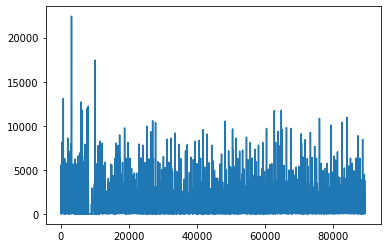

In [42]:
raw_data.content.apply(lambda x: len(str(x))).plot()

In [44]:
raw_data.content.apply(lambda x: len(str(x))).describe()

count    89611.000000
mean       432.278370
std        664.481698
min          3.000000
25%        129.000000
50%        171.000000
75%        484.000000
max      22422.000000
Name: content, dtype: float64

In [77]:
useless_index = []

for i, c in raw_data.content.items():
    if len(str(c)) <= 120:
        useless_index.append(i)
        if len(str(c)) > 100:
            print(raw_data.url[i], '||', raw_data.content[i])


# raw_data.content.isnull()

http://china.huanqiu.com/hot/2017-06/10866428.html || 免责声明：本文仅代表作者个人观点，与环球网无关。其原创性以及文中陈述文字和内容未经本站证实，对本文以及其中全部或者部分内容、文字的真实性、完整性、及时性本站不作任何保证或承诺，请读者仅作参考，并请自行核实相关内容。

http://www.cnbeta.com/articles/tech/623675.htm || 在此前的母亲节上，Google也将父母绘制成超萌的仙人掌。此外从近年来推出的Doodle上已经注意到不再局限于出现“Google”这样的字眼，在本周日发布的Doodle需要仔细观察才会注意到“g”这样的轮廓。

http://www.cankaoxiaoxi.com/society/20170623/2143479.shtml || 中新网6月23日电 据最高人民检察院网站消息，日前，经最高人民检察院指定管辖，内蒙古自治区人民检察院依法对神华宁夏煤业集团有限责任公司党委原副书记、纪委书记甄久春(正厅级)涉嫌受贿罪立案侦查。案件侦查工作正在进行中。

http://www.cankaoxiaoxi.com/society/rollwifi/20170623/2143480.shtml || 中新网6月23日电 据最高人民检察院网站消息，日前，经最高人民检察院指定管辖，内蒙古自治区人民检察院依法对神华宁夏煤业集团有限责任公司党委原副书记、纪委书记甄久春(正厅级)涉嫌受贿罪立案侦查。案件侦查工作正在进行中。

http://www.cankaoxiaoxi.com/china/20170623/2143487.shtml || 中新网6月23日电 据最高人民检察院网站消息，日前，经最高人民检察院指定管辖，内蒙古自治区人民检察院依法对神华宁夏煤业集团有限责任公司党委原副书记、纪委书记甄久春(正厅级)涉嫌受贿罪立案侦查。案件侦查工作正在进行中。

http://go.huanqiu.com/news/2016-10/9572362.html || 　　住房城乡建社部近日公布了第一批中国特色小镇名单，密云区古北口镇127个镇榜上有名。图为古北水镇通过发展特色旅游，成为集观光旅游、休闲度假、商务会展、创意文化功能为一体的北京地区文化旅游新地标和国际旅游综合目的地

http://home.xinhua-news.com/gdsdetailxhsnew/1819826-?pageflag=init&imageOrVedioTypeGdsId= || 新华社照片，外代，2017年4月7日\n（外代二线）“微型瑞士”展\n这是4月5日在瑞士梅利德拍摄的洛迦诺大广场模型。\n梅利德正在举行“微型瑞士”展览，展出多个瑞士著名建筑的模型。\n新华社/欧新\n
http://home.xinhua-news.com/gdsdetailxhsnew/1819824-?pageflag=init&imageOrVedioTypeGdsId= || 新华社照片，外代，2017年4月7日\n（外代二线）“微型瑞士”展\n4月5日，在瑞士梅利德，一名工作人员为洛迦诺大广场模型做最后的上色工作。\n梅利德正在举行“微型瑞士”展览，展出多个瑞士著名建筑的模型。\n新华社/欧新\n\n
http://home.xinhua-news.com/gdsdetailxhsnew/1819828-?pageflag=init&imageOrVedioTypeGdsId= || 新华社照片，外代，2017年4月7日\n（外代二线）“微型瑞士”展\n这是4月5日在瑞士梅利德拍摄的洛迦诺大广场模型一角。\n梅利德正在举行“微型瑞士”展览，展出多个瑞士著名建筑的模型。\n新华社/欧新\n\n
http://home.xinhua-news.com/gdsdetailxhsnew/1820004-?pageflag=init&imageOrVedioTypeGdsId= || 新华社照片，外代，2017年4月7日\n（外代二线）沙漠与火星\n3月7日，在智利阿塔卡马沙漠，游客在日落时拍摄照片。\n智利阿塔卡马沙漠是全球最干旱地区之一，与火星环境非常相似。\n新华社/法新\n\n
http://home.xinhua-news.com/gdsdetailxhsnew/1819999-?pageflag=init&imageOrVedioTypeGdsId= || 新华社照片，外代，2017年4月7日\n（外代二线）沙漠与火星\n3月7日，在智利阿塔卡马沙漠，生物学家寻找岩石样本进行研究分析。\n智利阿塔卡马沙漠是全球最干旱地区之一，与火星环境非常相似。\n新华社/法新\n\n

http://home.xinhua-news.com/gdsdetailxhsnew/1876206-?pageflag=init&imageOrVedioTypeGdsId= || 新华社照片，外代，2017年4月14日\n（外代二线）多款新车亮相纽约车展\n这是4月13日在美国纽约举行的国际汽车展上拍摄的玛莎拉蒂车标。\n2017纽约国际汽车展将于4月14日至23日对公众开放。\n新华社/路透
http://home.xinhua-news.com/gdsdetailxhsnew/1876150-?pageflag=init&imageOrVedioTypeGdsId= || 新华社照片，信阳（河南），2017年4月14日\n河南信阳：茶园采茶忙\n4月13日，茶农在信阳市浉河区浉河港镇郝家冲茶园内采茶。\n目前，正值河南信阳茶叶采摘上市的关键时期，当地各个茶园、茶场都能看到茶农们忙碌的身影。\n新华社记者李博摄
http://home.xinhua-news.com/gdsdetailxhsnew/1876204-?pageflag=init&imageOrVedioTypeGdsId= || 新华社照片，信阳（河南），2017年4月14日\n河南信阳：茶园采茶忙\n4月13日，茶农在信阳市浉河区浉河港镇郝家冲茶园内采茶。\n目前，正值河南信阳茶叶采摘上市的关键时期，当地各个茶园、茶场都能看到茶农们忙碌的身影。\n新华社记者李博摄
http://home.xinhua-news.com/gdsdetailxhsnew/1876207-?pageflag=init&imageOrVedioTypeGdsId= || 新华社照片，信阳（河南），2017年4月14日\n河南信阳：茶园采茶忙\n4月13日，茶农在信阳市浉河区浉河港镇一处茶园内采茶。\n目前，正值河南信阳茶叶采摘上市的关键时期，当地各个茶园、茶场都能看到茶农们忙碌的身影。\n新华社记者李博摄
http://home.xinhua-news.com/gdsdetailxhsnew/1876205-?pageflag=init&imageOrVedioTypeGdsId= || 新华社照片，信阳（河南），2017年4月14日\n河南信阳：茶园采茶忙\n这是4月13日拍摄的信阳市浉河区浉河港镇一处茶园。\n

http://home.xinhua-news.com/gdsdetailxhsnew/1933340-?pageflag=init&imageOrVedioTypeGdsId= || 新华社照片，外代，2017年4月21日\n（外代二线）马德里婚礼时装周——设计师胡安霍·奥利娃时装秀\n4月20日，在西班牙马德里婚礼时装周上，模特展示西班牙时装设计师胡安霍·奥利娃设计的作品。\n新华社/欧新\n
http://home.xinhua-news.com/gdsdetailxhsnew/1933338-?pageflag=init&imageOrVedioTypeGdsId= || 新华社照片，外代，2017年4月21日\n（外代二线）马德里婚礼时装周——设计师胡安霍·奥利娃时装秀\n4月20日，在西班牙马德里婚礼时装周上，模特展示西班牙时装设计师胡安霍·奥利娃设计的作品。\n新华社/欧新\n
http://home.xinhua-news.com/gdsdetailxhsnew/1933335-?pageflag=init&imageOrVedioTypeGdsId= || 新华社照片，外代，2017年4月21日\n（外代二线）马德里婚礼时装周——设计师胡安霍·奥利娃时装秀\n4月20日，在西班牙马德里婚礼时装周上，模特展示西班牙时装设计师胡安霍·奥利娃设计的作品。\n新华社/欧新\n
http://home.xinhua-news.com/gdsdetailxhsnew/1933352-?pageflag=init&imageOrVedioTypeGdsId= || 新华社照片，外代，2017年4月21日\n（外代二线）马德里婚礼时装周——设计师胡安娜·马丁时装秀\n4月20日，在西班牙马德里婚礼时装周上，模特展示西班牙时装设计师胡安娜·马丁设计的作品。\n新华社/欧新\n
http://home.xinhua-news.com/gdsdetailxhsnew/1933345-?pageflag=init&imageOrVedioTypeGdsId= || 新华社照片，外代，2017年4月21日\n（外代二线）马德里婚礼时装周——设计师胡安霍·奥利娃时装秀\n4月20日，在西班牙马德里婚礼时装周上，模特展示西班牙时装设计师胡安霍·奥利娃设计的作品。\n新华社/欧新

http://home.xinhua-news.com/gdsdetailxhsnew/1984303-?pageflag=init&imageOrVedioTypeGdsId= || 新华社照片，外代，2017年4月29日\n（外代二线）墨西哥时装周——设计师辛蒂娅·巴滕科勒普时装秀\n4月27日，在墨西哥首都墨西哥城举行的墨西哥时装周上，模特展示墨西哥时装设计辛蒂娅·巴滕科勒普设计的服装。\n新华社/欧新\n
http://home.xinhua-news.com/gdsdetailxhsnew/1984381-?pageflag=init&imageOrVedioTypeGdsId= || 新华社北京4月29日电记者从中国铁路总公司获悉，一列从英国伦敦始发的中欧班列29日顺利抵达浙江义乌，这是继今年1月1日义乌至伦敦中欧班列成功开行后，从伦敦返程的首列中欧班列。至此，中欧班列（义乌－伦敦）实现双向对开。（完）
http://home.xinhua-news.com/gdsdetailxhsnew/1984432-?pageflag=init&imageOrVedioTypeGdsId= || 新华社照片，南昌，2017年4月29日\n南昌铁路局迎来“五一”小长假出行客流高峰\n4月29日，在南昌西站，旅客在候车。\n当日是“五一”小长假的第一天，南昌铁路局迎来假期出行客流高峰。\n新华社记者彭昭之摄
http://home.xinhua-news.com/gdsdetailxhsnew/1984430-?pageflag=init&imageOrVedioTypeGdsId= || 新华社照片，南昌，2017年4月29日\n南昌铁路局迎来“五一”小长假出行客流高峰\n4月29日，在南昌西站，旅客排队上车。\n当日是“五一”小长假的第一天，南昌铁路局迎来假期出行客流高峰。\n新华社记者彭昭之摄
http://home.xinhua-news.com/gdsdetailxhsnew/1984433-?pageflag=init&imageOrVedioTypeGdsId= || 新华社照片，南昌，2017年4月29日\n南昌铁路局迎来“五一”小长假出行客流高峰\n4月29日，在南昌西站，旅客进站乘车。\n当日是“五一”小长假的第一天，南昌铁路局迎来假期出行客流高峰

http://home.xinhua-news.com/gdsdetailxhsnew/2031767-?pageflag=init&imageOrVedioTypeGdsId= || 新华社照片，外代，2017年5月8日\n（外代二线）足球——法甲联赛：马赛胜尼斯\n5月7日，马赛队球员埃夫拉（右二）攻门得分。\n当日，在2016-2017赛季法国足球甲级联赛第36轮比赛中，马赛队主场以2比1战胜尼斯队。\n新华社/法新
http://home.xinhua-news.com/gdsdetailxhsnew/2031781-?pageflag=init&imageOrVedioTypeGdsId= || 新华社照片，外代，2017年5月8日\n（外代二线）足球——法甲联赛：马赛胜尼斯\n5月7日，马赛队球员佩耶（前）带球进攻。\n当日，在2016-2017赛季法国足球甲级联赛第36轮比赛中，马赛队主场以2比1战胜尼斯队。\n新华社/法新
http://home.xinhua-news.com/gdsdetailxhsnew/2031772-?pageflag=init&imageOrVedioTypeGdsId= || 新华社照片，外代，2017年5月8日\n（外代二线）足球——法甲联赛：马赛胜尼斯\n5月7日，马赛队主帅加西亚场边指挥。\n当日，在2016-2017赛季法国足球甲级联赛第36轮比赛中，马赛队主场以2比1战胜尼斯队。\n新华社/法新
http://home.xinhua-news.com/gdsdetailxhsnew/2031777-?pageflag=init&imageOrVedioTypeGdsId= || 新华社照片，外代，2017年5月8日\n（外代二线）足球——法甲联赛：马赛胜尼斯\n5月7日，马赛队守门员帕莱（右二）扑出险球。\n当日，在2016-2017赛季法国足球甲级联赛第36轮比赛中，马赛队主场以2比1战胜尼斯队。\n新华社/法新
http://home.xinhua-news.com/gdsdetailxhsnew/2031779-?pageflag=init&imageOrVedioTypeGdsId= || 新华社照片，外代，2017年5月8日\n（外代二线）足球——法甲联赛：马赛胜尼斯\n5月7日，马赛队球员赛后向观众

http://home.xinhua-news.com/gdsdetailxhsnew/2078358-?pageflag=init&imageOrVedioTypeGdsId= || \n“一带一路”国际合作高峰论坛在北京国家会议中心四层大会堂正式拉开帷幕。世界的目光再次聚焦北京，对于这次会议，设置哪些议题，又有哪些看点。\n视频编辑：刘媛媛\n编辑：吴建青\n中国新华新闻电视网\n
http://home.xinhua-news.com/gdsdetailxhsnew/2078443-?pageflag=init&imageOrVedioTypeGdsId= || 新华社照片，北京，2017年5月15日\n李克强会见联合国秘书长古特雷斯\n5月15日，国务院总理李克强在北京人民大会堂会见来华出席“一带一路”国际合作高峰论坛的联合国秘书长古特雷斯。\n新华社记者张铎摄
http://home.xinhua-news.com/gdsdetailxhsnew/2078589-?pageflag=init&imageOrVedioTypeGdsId= || 新华社照片，北京，2017年5月15日\n刘云山会见中间民主党国际主席、哥伦比亚前总统帕斯特拉纳\n5月15日，中共中央政治局常委、中央书记处书记刘云山在北京会见中间民主党国际主席、哥伦比亚前总统帕斯特拉纳。\n新华社记者丁林摄\n
http://home.xinhua-news.com/gdsdetailxhsnew/2081092-?pageflag=init&imageOrVedioTypeGdsId= || 新华社摄影部今日重要稿件预告\n\n今日要闻：\n1.（国际）联合国特使说相信叙政府有政治解决冲突的意愿（已发4张）\n2.（科技）第四届中国机器人峰会开幕（预计下午播发）\n\n新华社摄影部\n2017年5月16日11时
http://home.xinhua-news.com/gdsdetailxhsnew/2081843-?pageflag=init&imageOrVedioTypeGdsId= || 新华社照片，外代，2017年5月16日\n（外代二线）澳大利亚时装周——设计师史蒂文·哈利勒作品时装秀\n5月15日，在澳大利亚悉尼举行的澳大利亚时装周上，模特展示本土设计师史蒂文·哈利勒设计的服装新品

http://home.xinhua-news.com/gdsdetailxhsnew/2126996-?pageflag=init&imageOrVedioTypeGdsId= || 新华社照片，外代，2017年5月24日\n（外代二线）足球——墨西哥队备战友谊赛\n5月23日，墨西哥队门将塔拉韦拉在训练中。\n当日，墨西哥队在墨西哥城进行赛前训练，备战即将与克罗地亚队进行的一场友谊赛。\n新华社/路透
http://home.xinhua-news.com/gdsdetailxhsnew/2126993-?pageflag=init&imageOrVedioTypeGdsId= || 新华社照片，外代，2017年5月24日\n（外代二线）足球——墨西哥队备战友谊赛\n5月23日，墨西哥队球员马克斯（左）和加利亚多在训练中。\n当日，墨西哥队在墨西哥城进行赛前训练，备战即将与克罗地亚队进行的一场友谊赛。\n新华社/路透
http://home.xinhua-news.com/gdsdetailxhsnew/2126995-?pageflag=init&imageOrVedioTypeGdsId= || 新华社照片，外代，2017年5月24日\n（外代二线）足球——墨西哥队备战友谊赛\n5月23日，墨西哥队门将奥乔亚在训练中。\n当日，墨西哥队在墨西哥城进行赛前训练，备战即将与克罗地亚队进行的一场友谊赛。\n新华社/路透
http://home.xinhua-news.com/gdsdetailxhsnew/2127000-?pageflag=init&imageOrVedioTypeGdsId= || 新华社照片，外代，2017年5月24日\n（外代二线）足球——墨西哥队备战友谊赛\n5月23日，墨西哥队球员瓜尔达多（右）和马克斯在训练中。\n当日，墨西哥队在墨西哥城进行赛前训练，备战即将与克罗地亚队进行的一场友谊赛。\n新华社/路透
http://home.xinhua-news.com/gdsdetailxhsnew/2126998-?pageflag=init&imageOrVedioTypeGdsId= || 新华社照片，外代，2017年5月24日\n（外代二线）足球——墨西哥队备战友谊赛\n5月23日，墨西哥队主教练奥索里奥指导球员训练。\n当日，墨西哥

http://home.xinhua-news.com/gdsdetailxhsnew/2181365-?pageflag=init&imageOrVedioTypeGdsId= || 新华社照片，布鲁塞尔，2017年6月2日\n李克强出席中欧工商峰会并发表演讲\n当地时间6月2日上午，国务院总理李克强在布鲁塞尔埃格蒙宫与欧盟委员会主席容克共同出席中欧工商峰会并发表演讲。\n新华社记者王晔摄
http://home.xinhua-news.com/gdsdetailxhsnew/2181462-?pageflag=init&imageOrVedioTypeGdsId= || 新华社照片，布鲁塞尔，2017年6月2日\n李克强同中欧中小企业家交流互动\n当地时间6月2日上午，国务院总理李克强在布鲁塞尔埃格蒙宫与参加中国－欧盟中小企业合作对接会的代表互动交流。欧盟委员会主席容克陪同参加。\n新华社记者王晔摄
http://home.xinhua-news.com/gdsdetailxhsnew/2182239-?pageflag=init&imageOrVedioTypeGdsId= || 　　新华社联合国６月２日电联合国安理会２日一致通过决议，强烈谴责朝鲜核导活动，并将更多相关个人和实体列入制裁名单。\n　　根据决议，朝鲜１４人被列入旅行禁令和资产冻结制裁名单、４个实体被列入资产冻结制裁名单。（完）
http://home.xinhua-news.com/gdsdetailxhsnew/2182240-?pageflag=init&imageOrVedioTypeGdsId= || 　　新华社联合国６月２日电联合国安理会２日一致通过决议，强烈谴责朝鲜核导活动，并将更多相关个人和实体列入制裁名单。\n　　根据决议，朝鲜１４人被列入旅行禁令和资产冻结制裁名单、４个实体被列入资产冻结制裁名单。（完）
http://home.xinhua-news.com/gdsdetailxhsnew/2182450-?pageflag=init&imageOrVedioTypeGdsId= || 新华社照片，巴黎，2017年6月3日\n（体育）（2）网球——风雨将至\n6月2日，焦科维奇与施瓦茨曼比赛时球场上方阴云密布。\n当日，2017法国网球公开赛在法国巴黎罗兰加洛斯球场进入第六个比

In [78]:
len(useless_index)

17971

In [91]:
useless_index_long = []

for i, c in raw_data.content.items():
    if len(str(c)) <= 30000:
        useless_index_long.append(i)
        if len(str(c)) > 10000:
            print(raw_data.url[i], 'Len: ',len(str(c)))
            print('index(pandas中):', i)
            print(raw_data.content[i][:500])
            print('=========')
            print(raw_data.content[i][-500:])
            print('#########')
            print()

http://news.163.com/17/0619/22/CNB0MNP800018M4D.html Len:  13096
index(pandas中): 700
编者注：人口失踪对很多人来说并不算新闻，而在美国，据信有1600多人了无痕迹的消失在了公共的土地之上，其中的大多数至今仍未找到，就算能够找到残骸，多数也不知道为何失踪。对失踪的人来说，如果失踪地在野外，可能除了亲人，没有人会坚持把他们找回家。
作者|Jon Billman?译者|颖琪?校对|张海冰 编辑|吴頔
2015年7月23日是约瑟夫·劳埃德·凯勒19岁生日的前一天。凯勒来自田纳西州克利夫兰，就读于克里夫兰州立社区学院，暑假开学后就要上大二了。暑假期间，他与好哥们科林·格沃特尼和克里斯蒂安·费茨纳一起，开着格沃特尼的老式斯巴鲁，去了美国西部公路旅行。他们先经过了拉斯维加斯、圣弗朗西斯科和科罗拉多大峡谷，然后去了乔的阿姨和姨夫家的度假牧场，那个牧场叫“虹鳟牧场”（the Rainbow Trout Ranch），在科罗拉多州西南部的圣胡安山脉里。
虹鳟牧场位于科内霍斯县，那是个比罗德岛大些的县城，有8000个居民，整个县城没有任何红绿灯。羊群在阳光下吃草；田里种着马铃薯和大麦，收割后被装上卡车，运往北部的丹佛。县里的奥东尼托小镇上新开了三家大麻药房，吸引着许多新墨西哥州人跨越附
。“晚餐前一小时的锻炼期间，不应该会发生这种事，”佐伊说：“他们三个人连开了24小时的车，径直赶到了虹鳟度假牧场。”他们已经一整天没有睡觉了，乔甚至还与他大卫叔叔的老父亲——75岁的道格·凡·贝克姆一起劈了柴。她无法相信她的儿子会跑到峡谷边沿——她坚持说乔并不喜欢高处，而且也不是个攀岩者。“我感觉，可能还有些事是我们不知道的。”
而放下疑虑和揣测是非常困难的。我们永远无法确定乔·凯勒的身上到底发生了什么。对于更多在野外失踪的其他人员，我们知道的甚至更少。
前面我问了一个问题：国家森林和沃尔玛停车场，你认为在哪个地方失踪会更好一些？我想我已经有了答案。你可以轻易地在智能手机上看到我家柴草堆的航拍影像，所以我原本以为，一旦你在野外失踪，有人会派国民警卫队、巡护护林员、精英团队进行搜救，找不到你绝不休息。但现在我不那么确定了。
标题：How 1,600 People Went Missing from Our Public La

In [92]:
useless_index.extend([3117,6221, 10052, 27862,62823, 48328,62823,76116,79555, 82780, 84244])

#### 发现：content内容中多次出现"外代二线"的新闻没有summarize的需要，处理时应该删除

In [104]:
useless_index_words = []

def deal_some_words():
    t = 0
    for i, c in raw_data.content.items():
        t += 1
        split_res = str(c).split('外代二线')
        if len(split_res) >= 6:
            useless_index_words.append(i)
            if t % 5 == 0:
                print(raw_data.url[i], 'Len: ',len(str(c)))
                print('index(pandas中):', i)
                print(raw_data.content[i][:500])
                print('=========')
                print(raw_data.content[i][-500:])
                print('#########')
                print()
                
deal_some_words()

http://home.xinhua-news.com/gdsdetailxhsnew/1782683-?pageflag=init&imageOrVedioTypeGdsId= Len:  5509
index(pandas中): 12404
中国新闻：\n\n*(文化)(3)《大宋·东京梦华》再现“宋韵清明”\n\n*新华社摄影部今日重要稿件预告\n\n*(春季美丽生态)(7)春和景明古荡口\n\n*(经济)(7)清明时节西湖龙井采茶忙\n\n*(体育·调研)(7)《热与冷的交汇——中国南方如何开展冰雪运动》系列报道之十一：上海篇\n\n*(新华全媒头条·图文互动)(8)以生命共赴使命——祭奠脱贫攻坚英雄\n\n*(文化)(2)北京海洋馆海洋文化踏青季拉开序幕\n\n*(环境)(4)湖南4月1日起正式入汛\n\n*(社会)(11)清明前夕缅怀先烈\n\n*(社会)(2)树文明家风过节俭清明\n\n*(社会)(4)南昌：集体追思文明过节\n\n*(环境)(3)万鸟临海\n\n*(社会)(2)做青团学文化\n\n*(社会)(3)长春为视觉障碍者举办文明祭祀公益活动\n\n*(科技)(16)神奇“大白鲸”升空记\n\n*(体育)(1)武术——八旬拳师义务授徒五十余载弘扬传统武术\n\n*(文化)(5)“明星漾衣”时装发布会在京举行\n\n*(文化)(4)四川兴文苗族群众欢度“花山节”\n\n*(教育)(3)“清明文化”进校园\n
]（外代二线）花样滑冰——世锦赛女子单人滑赛况\n\n*[10]（外代二线）花样滑冰——世锦赛女子单人滑赛况\n\n*[17]（外代二线）花样滑冰——世锦赛女子单人滑赛况\n\n*[18]（外代二线）花样滑冰——世锦赛女子单人滑赛况\n\n*[19]（外代二线）花样滑冰——世锦赛女子单人滑赛况\n\n*[14]（外代二线）花样滑冰——世锦赛女子单人滑赛况\n\n*[15]（外代二线）花样滑冰——世锦赛女子单人滑赛况\n\n*[16]（外代二线）花样滑冰——世锦赛女子单人滑赛况\n\n*[24]（外代二线）花样滑冰——世锦赛女子单人滑赛况\n\n*[25]（外代二线）花样滑冰——世锦赛女子单人滑赛况\n\n*[26]（外代二线）花样滑冰——世锦赛女子单人滑赛况\n\n*[27]（外代二线）花样滑冰——世锦赛女子单人滑赛况\n\n*[20]（外代

In [105]:
len(useless_index_words)

219

In [106]:
for i in useless_index_words:
    if i not in useless_index:
        useless_index.append(i)

#### 删除

In [107]:
data = raw_data.drop(pd.Index(useless_index))

In [108]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71418 entries, 0 to 89610
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       71418 non-null  int64 
 1   author   62129 non-null  object
 2   source   71416 non-null  object
 3   content  71418 non-null  object
 4   feature  71418 non-null  object
 5   title    71418 non-null  object
 6   url      71418 non-null  object
dtypes: int64(1), object(6)
memory usage: 4.4+ MB


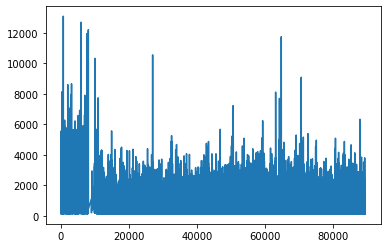

In [109]:
data.content.apply(lambda x: len(str(x))).plot()

In [110]:
data.content.apply(lambda x: len(str(x))).describe()

count    71418.000000
mean       504.938573
std        636.353899
min        121.000000
25%        148.000000
50%        233.000000
75%        595.000000
max      13096.000000
Name: content, dtype: float64

In [111]:
data.to_csv('clean_data_len_gt_120.csv', encoding='utf-8')

In [112]:
del raw_data

### Model

In [1]:
import pandas as pd

In [2]:
data = pd.read_csv('clean_data_len_gt_120.csv', encoding='utf-8')

In [38]:
from pyltp import SentenceSplitter  # 淘汰

In [39]:
def split_sentence(doc):
#     doc = doc.strip().replace(u'\u3000', u'').replace(u'\\n', u'。').replace(u'(。)+', u'。').replace(' ', '')
    return [sent for sent in SentenceSplitter.split(doc)]

In [40]:
for i in SentenceSplitter.split('经济观察网 杨国英/文 中美贸易的转折，或从“美国牛肉入华”再起步！'):
    print(i)

经济观察网 杨国英/文 中美贸易的转折，或从“美国牛肉入华”再起步！


In [41]:
for i in SentenceSplitter.split(data.content[1312]):
    print(i)

（原标题：网传石燕湖教练骚扰女大学生 景区回应停职处理）

长沙知名本地博主“长沙热点集”发文，受网友关注。


事发当时情况。
来自微博网友

石燕湖景区发布公告。


网友表示亲眼所见。


评论分化，有网友质疑事件真实；
也有网友认为景区雇了“水军。”


红网长沙6月12日讯6月11日下午，长沙知名本地博主“长沙热点集”发文称，有女同学在石燕湖遭教官乘机摸屁股、抹腰等，并配有涉事教官照片。
截至今日傍晚，该条微博已有近5000人点赞，近2000人参与评论，引起网友关注。


今日下午6点左右，长沙石燕湖景区通过微博发布声明，表示该事件在警方介入下已得到解决，涉事教练被停职处理。


如今，暑期旅游旺季已经来临，在扎堆旅游时，弱势群体应当如何保护自己不受侵害？
时刻新闻特向律师取经，送上小贴士。


网传女大学生被摸屁股

11日，微博博主“长沙热点集”发文称，一女同学在长沙石燕湖景区遭教练摸屁股、抹腰。
在该条微博的评论里，一网友表示自己当时在场，游戏结束时，看到教官在帮女同学把数据接口拔掉（模拟枪击项目）时，趁机摸女同学的腰和屁股，就愤怒质疑，“你拔个接口还要摸屁股的？”


另有网友回复，“今天去玩的时候确实看到有这么一件事，”网友称，当时看到当事人一直在哭，且导游得知多人被摸后，曾马上冲进去找人。


时刻新闻记者辗转联系到受害人之一，这名女大学生表示情况属实，自己目前在湖南某高校读大一，当时是与几个班一同去参加拓展活动。
而对于事件细节，她表示不愿再回忆。


评论分化被质疑有“水军”

女大学生被摸，这样的事情遭到了众多网友的同情，网友纷纷谴责那个教练。
“太恶心了！”
“这个教练要开除吧！”
“不要因一颗老鼠屎，坏了一锅粥！”


但同时，在评论中，也有人发表诸如“摸屁股也算猥亵？”
“哪天我拍你两张照片，说你强奸我”等言论。
对于这样的观点，网友们分化展开激烈口角。


有细心的网友发现，评论中有不少人是石燕湖景区管理方中惠旅公司的员工，因此质疑景区请了“水军”来引导舆论。


后续发展：景区称涉事教练已停职

今日下午6时左右，长沙石燕湖风景区官方微博发出声明表示，通过警方介入和双方沟通，事情已得到妥善处理，涉事教练已经被停职处理，今后将加强管理，避免类似事情的发生。


“如果女生反映的情况属实，那么这种行为就构成性骚扰，如果给当事人在精神

In [50]:
import re
from functools import reduce


def split_to_sentence(doc, min_len=6):
    """自定义的分段分句
    
    return:
        list, 储存内容为每一段分句结果的list，index信息可以用于后续位置特征计算
    """
#     pattern = re.compile(".*?[。?？!！]")  # 非贪婪模式匹配文字内容
    
    paragraph_gen = split_to_paragraph(doc)
    doc_content = []
    for para in paragraph_gen:
        if para is None:
            continue
        elif len(para) <= min_len:
            continue
        
        doc_content.append(split_sentence(para))
#         elif para.strip()[-1] in '。?？!！"“”':
#             sent_of_para = re.findall(pattern, para)
#             doc_content.append(sent_of_para)
#         else: 
#             doc_content.append([para])
            
    return doc_content


def split_to_paragraph(doc):
    """为了识别靠近段开头和结尾位置，需要单独输出句子位置特征
    
    return:
        filter结果生成器
    """
    pattern = re.compile(r"(\r\n\u3000\u3000)|(\r\n)|(\u3000\u3000)|(\\n)")
    res = re.split(pattern, doc)
    for i in res:
        if i and len(i) > 5:
            yield i

In [250]:
list(split_to_paragraph(data.content[1312]))

['（原标题：网传石燕湖教练骚扰女大学生 景区回应停职处理）',
 '长沙知名本地博主“长沙热点集”发文，受网友关注。',
 '事发当时情况。 来自微博网友',
 '石燕湖景区发布公告。',
 '网友表示亲眼所见。',
 '评论分化，有网友质疑事件真实；也有网友认为景区雇了“水军。”',
 '红网长沙6月12日讯6月11日下午，长沙知名本地博主“长沙热点集”发文称，有女同学在石燕湖遭教官乘机摸屁股、抹腰等，并配有涉事教官照片。截至今日傍晚，该条微博已有近5000人点赞，近2000人参与评论，引起网友关注。',
 '今日下午6点左右，长沙石燕湖景区通过微博发布声明，表示该事件在警方介入下已得到解决，涉事教练被停职处理。',
 '如今，暑期旅游旺季已经来临，在扎堆旅游时，弱势群体应当如何保护自己不受侵害？时刻新闻特向律师取经，送上小贴士。',
 '网传女大学生被摸屁股',
 '11日，微博博主“长沙热点集”发文称，一女同学在长沙石燕湖景区遭教练摸屁股、抹腰。在该条微博的评论里，一网友表示自己当时在场，游戏结束时，看到教官在帮女同学把数据接口拔掉（模拟枪击项目）时，趁机摸女同学的腰和屁股，就愤怒质疑，“你拔个接口还要摸屁股的？”',
 '另有网友回复，“今天去玩的时候确实看到有这么一件事，”网友称，当时看到当事人一直在哭，且导游得知多人被摸后，曾马上冲进去找人。',
 '时刻新闻记者辗转联系到受害人之一，这名女大学生表示情况属实，自己目前在湖南某高校读大一，当时是与几个班一同去参加拓展活动。而对于事件细节，她表示不愿再回忆。',
 '评论分化被质疑有“水军”',
 '女大学生被摸，这样的事情遭到了众多网友的同情，网友纷纷谴责那个教练。“太恶心了！”“这个教练要开除吧！”“不要因一颗老鼠屎，坏了一锅粥！”',
 '但同时，在评论中，也有人发表诸如“摸屁股也算猥亵？”“哪天我拍你两张照片，说你强奸我”等言论。对于这样的观点，网友们分化展开激烈口角。',
 '有细心的网友发现，评论中有不少人是石燕湖景区管理方中惠旅公司的员工，因此质疑景区请了“水军”来引导舆论。',
 '后续发展：景区称涉事教练已停职',
 '今日下午6时左右，长沙石燕湖风景区官方微博发出声明表示，通过警方介入和双方沟通，事情已得到妥善处理，涉事教练已经被停职处理，今后将加强管理，避免类似事情的发生。',
 '

In [45]:
split_to_sentence(data.content[1312])

[['（原标题：网传石燕湖教练骚扰女大学生 景区回应停职处理）'],
 ['长沙知名本地博主“长沙热点集”发文，受网友关注。'],
 ['事发当时情况。', '来自微博网友'],
 ['石燕湖景区发布公告。'],
 ['网友表示亲眼所见。'],
 ['评论分化，有网友质疑事件真实；', '也有网友认为景区雇了“水军。”'],
 ['红网长沙6月12日讯6月11日下午，长沙知名本地博主“长沙热点集”发文称，有女同学在石燕湖遭教官乘机摸屁股、抹腰等，并配有涉事教官照片。',
  '截至今日傍晚，该条微博已有近5000人点赞，近2000人参与评论，引起网友关注。'],
 ['今日下午6点左右，长沙石燕湖景区通过微博发布声明，表示该事件在警方介入下已得到解决，涉事教练被停职处理。'],
 ['如今，暑期旅游旺季已经来临，在扎堆旅游时，弱势群体应当如何保护自己不受侵害？', '时刻新闻特向律师取经，送上小贴士。'],
 ['网传女大学生被摸屁股'],
 ['11日，微博博主“长沙热点集”发文称，一女同学在长沙石燕湖景区遭教练摸屁股、抹腰。',
  '在该条微博的评论里，一网友表示自己当时在场，游戏结束时，看到教官在帮女同学把数据接口拔掉（模拟枪击项目）时，趁机摸女同学的腰和屁股，就愤怒质疑，“你拔个接口还要摸屁股的？”'],
 ['另有网友回复，“今天去玩的时候确实看到有这么一件事，”网友称，当时看到当事人一直在哭，且导游得知多人被摸后，曾马上冲进去找人。'],
 ['时刻新闻记者辗转联系到受害人之一，这名女大学生表示情况属实，自己目前在湖南某高校读大一，当时是与几个班一同去参加拓展活动。',
  '而对于事件细节，她表示不愿再回忆。'],
 ['评论分化被质疑有“水军”'],
 ['女大学生被摸，这样的事情遭到了众多网友的同情，网友纷纷谴责那个教练。',
  '“太恶心了！”',
  '“这个教练要开除吧！”',
  '“不要因一颗老鼠屎，坏了一锅粥！”'],
 ['但同时，在评论中，也有人发表诸如“摸屁股也算猥亵？”',
  '“哪天我拍你两张照片，说你强奸我”等言论。',
  '对于这样的观点，网友们分化展开激烈口角。'],
 ['有细心的网友发现，评论中有不少人是石燕湖景区管理方中惠旅公司的员工，因此质疑景区请了“水军”来引导舆论。'],
 ['后续发展：景区称涉事教

In [4]:
data.content[1]

'骁龙835作为唯一通过Windows 10桌面平台认证的ARM处理器，高通强调，不会因为只考虑性能而去屏蔽掉小核心。相反，他们正联手微软，找到一种适合桌面平台的、兼顾性能和功耗的完美方案。\r\n报道称，微软已经拿到了一些新的源码，以便Windows 10更好地理解big.little架构。\r\n资料显示，骁龙835作为一款集成了CPU、GPU、基带、蓝牙/Wi-Fi的SoC，比传统的Wintel方案可以节省至少30%的PCB空间。\r\n按计划，今年Q4，华硕、惠普、联想将首发骁龙835 Win10电脑，预计均是二合一形态的产品。\r\n当然，高通骁龙只是个开始，未来也许还能见到三星Exynos、联发科、华为麒麟、小米澎湃等进入Windows 10桌面平台。\r\n'

In [5]:
for i in split_to_paragraph(data.content[1]):
    print(i)

骁龙835作为唯一通过Windows 10桌面平台认证的ARM处理器，高通强调，不会因为只考虑性能而去屏蔽掉小核心。相反，他们正联手微软，找到一种适合桌面平台的、兼顾性能和功耗的完美方案。
报道称，微软已经拿到了一些新的源码，以便Windows 10更好地理解big.little架构。
资料显示，骁龙835作为一款集成了CPU、GPU、基带、蓝牙/Wi-Fi的SoC，比传统的Wintel方案可以节省至少30%的PCB空间。
按计划，今年Q4，华硕、惠普、联想将首发骁龙835 Win10电脑，预计均是二合一形态的产品。
当然，高通骁龙只是个开始，未来也许还能见到三星Exynos、联发科、华为麒麟、小米澎湃等进入Windows 10桌面平台。


#### 分词

In [9]:
import jieba

from pyhanlp import *

from gensim.models import FastText
from gensim.models.word2vec import LineSentence

In [9]:
# startJVM(getDefaultJVMPath(), "-Djava.class.path=/home/deepspeed/.local/lib/python3.6/site-packages/pyhanlp/static/hanlp-1.7.7.jar:/home/deepspeed/.local/lib/python3.6/site-packages/pyhanlp/static",
#          "-Xms1g",
#          "-Xmx1g")

# HanLP = JClass('com.hankcs.hanlp.HanLP')

#### 几种主流分词器对比

In [10]:
def cut(string): return ' '.join(jieba.cut(string))

In [11]:
s = '从大的环境上来看，市场目前本身不具备大面积和大空间的反弹基础，因为目前无论是从宏观面、货币基本面或者从国际经济和政治的角度来看，都不具备这样的条件，所以反应到市场中来，只能是结构性、局部性的投机性机会。而最近半个月以来，市场的走势也确实符合局部性、结构性投机的走势。'
cut(s)

Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 0.783 seconds.
Prefix dict has been built successfully.


'从 大 的 环境 上 来看 ， 市场 目前 本身 不 具备 大面积 和 大 空间 的 反弹 基础 ， 因为 目前 无论是 从 宏观 面 、 货币 基本面 或者 从 国际 经济 和 政治 的 角度 来看 ， 都 不 具备 这样 的 条件 ， 所以 反应 到 市场 中来 ， 只能 是 结构性 、 局部性 的 投机性 机会 。 而 最近 半个 月 以来 ， 市场 的 走势 也 确实 符合 局部性 、 结构性 投机 的 走势 。'

In [12]:
print(HanLP.segment(s))

[从/p, 大/a, 的/ude1, 环境/n, 上/f, 来看/u, ，/w, 市场/n, 目前/t, 本身/rz, 不具备/v, 大面积/d, 和/cc, 大/a, 空间/n, 的/ude1, 反弹/vi, 基础/n, ，/w, 因为/c, 目前/t, 无论是/c, 从/p, 宏观/n, 面/nf, 、/w, 货币/n, 基本面/n, 或者/c, 从/p, 国际/n, 经济/n, 和/cc, 政治/n, 的/ude1, 角度/n, 来看/u, ，/w, 都/d, 不/d, 具备/v, 这样/rzv, 的/ude1, 条件/n, ，/w, 所以/c, 反应/vn, 到/v, 市场/n, 中/f, 来/vf, ，/w, 只能/v, 是/vshi, 结构性/n, 、/w, 局部性/n, 的/ude1, 投机性/n, 机会/n, 。/w, 而/cc, 最近/t, 半/mq, 个/q, 月/n, 以来/f, ，/w, 市场/n, 的/ude1, 走势/n, 也/d, 确实/ad, 符合/v, 局部性/n, 、/w, 结构性/n, 投机/vn, 的/ude1, 走势/n, 。/w]


In [41]:
print(StandardTokenizer.segment(data.content[1]))

[骁龙/nr, 835/m, 作为/p, 唯一/b, 通过/p, Windows/nx,  /w, 10/m, 桌面/n, 平台/n, 认证/vn, 的/ude1, ARM/nx, 处理器/n, ，/w, 高通/nr, 强调/v, ，/w, 不会/v, 因为/c, 只/d, 考虑/v, 性能/n, 而/cc, 去/vf, 屏蔽掉/i, 小/a, 核心/n, 。/w, 相反/vi, ，/w, 他们/rr, 正/d, 联手/vd, 微软/ntc, ，/w, 找到/v, 一/m, 种/q, 适合/v, 桌面/n, 平台/n, 的/ude1, 、/w, 兼顾/v, 性能/n, 和/cc, 功耗/gi, 的/ude1, 完美/a, 方案/n, 。/w, 
/w, 报道/v, 称/v, ，/w, 微软/ntc, 已经/d, 拿到/v, 了/ule, 一些/m, 新的/a, 源码/n, ，/w, 以便/d, Windows/nx,  /w, 10/m, 更好/d, 地/ude2, 理解/v, big/nx, ./w, little/nx, 架构/n, 。/w, 
/w, 资料/n, 显示/v, ，/w, 骁/ng, 龙/n, 835/m, 作为/p, 一/m, 款/q, 集成/vn, 了/ule, CPU/nx, 、/w, GPU/nx, 、/w, 基带/nz, 、/w, 蓝牙/n, //w, Wi-Fi/nx, 的/ude1, SoC/nx, ，/w, 比/p, 传统/n, 的/ude1, Wintel/nx, 方案/n, 可以/v, 节省/v, 至少/d, 30/m, %/nx, 的/ude1, PCB/nx, 空间/n, 。/w, 
/w, 按计划/d, ，/w, 今年/t, Q/nx, 4/m, ，/w, 华硕/ntc, 、/w, 惠普/ntc, 、/w, 联想/vi, 将/d, 首发/v, 骁/ng, 龙/n, 835/m,  /w, Win/nx, 10/m, 电脑/n, ，/w, 预计/v, 均/d, 是/vshi, 二合一/nz, 形态/n, 的/ude1, 产品/n, 。/w, 
/w, 当然/d, ，/w, 高通骁/nr, 龙/n, 只是/d, 个/q, 开始/v, ，/w, 未来/t, 也许/d, 还/d, 能/v, 见到/v, 三星/ntc, Exynos

In [13]:
StandardTokenizer = JClass('com.hankcs.hanlp.tokenizer.StandardTokenizer')
print(StandardTokenizer.segment(s))

[从/p, 大/a, 的/ude1, 环境/n, 上/f, 来看/u, ，/w, 市场/n, 目前/t, 本身/rz, 不具备/v, 大面积/d, 和/cc, 大/a, 空间/n, 的/ude1, 反弹/vi, 基础/n, ，/w, 因为/c, 目前/t, 无论是/c, 从/p, 宏观/n, 面/nf, 、/w, 货币/n, 基本面/n, 或者/c, 从/p, 国际/n, 经济/n, 和/cc, 政治/n, 的/ude1, 角度/n, 来看/u, ，/w, 都/d, 不/d, 具备/v, 这样/rzv, 的/ude1, 条件/n, ，/w, 所以/c, 反应/vn, 到/v, 市场/n, 中/f, 来/vf, ，/w, 只能/v, 是/vshi, 结构性/n, 、/w, 局部性/n, 的/ude1, 投机性/n, 机会/n, 。/w, 而/cc, 最近/t, 半/mq, 个/q, 月/n, 以来/f, ，/w, 市场/n, 的/ude1, 走势/n, 也/d, 确实/ad, 符合/v, 局部性/n, 、/w, 结构性/n, 投机/vn, 的/ude1, 走势/n, 。/w]


In [14]:
# 带命名实体识别
NLPTokenizer = JClass('com.hankcs.hanlp.tokenizer.NLPTokenizer')
print(NLPTokenizer.segment(s))

[从/p, 大/a, 的/u, 环境/n, 上/f, 来看/v, ，/w, 市场/n, 目前/t, 本身/r, 不/d, 具备/v, 大面积/n, 和/c, 大/a, 空间/n, 的/u, 反弹/vn, 基础/n, ，/w, 因为/c, 目前/t, 无论是/d, 从/p, 宏观/n, 面/n, 、/w, 货币/n, 基本面/n, 或者/c, 从/p, 国际/n, 经济/n, 和/c, 政治/n, 的/u, 角度/n, 来看/v, ，/w, 都/d, 不/d, 具备/v, 这样/r, 的/u, 条件/n, ，/w, 所以/c, 反应/v, 到/p, 市场/n, 中/f, 来/v, ，/w, 只能/v, 是/v, 结构性/n, 、/w, 局部性/n, 的/u, 投机性/n, 机会/n, 。/w, 而/c, 最近/t, 半个月/t, 以来/f, ，/w, 市场/n, 的/u, 走势/n, 也/d, 确实/ad, 符合/v, 局部性/n, 、/w, 结构性/n, 投机/vn, 的/u, 走势/n, 。/w]


In [15]:
string = '''网易娱乐7月21日报道 林肯公园主唱查斯特·贝宁顿Chester Bennington于今天早上，在洛杉矶帕洛斯弗迪斯的一个私人庄园自缢身亡，年仅41岁。此消息已得到洛杉矶警方证实。
　　洛杉矶警方透露，Chester的家人正在外地度假，Chester独自在家，上吊地点是家里的二楼。一说是一名音乐公司工作人员来家里找他时发现了尸体，也有人称是佣人最早发现其死亡。
　　林肯公园另一位主唱麦克·信田确认了Chester Bennington自杀属实，并对此感到震惊和心痛，称稍后官方会发布声明。Chester昨天还在推特上转发了一条关于曼哈顿垃圾山的新闻。粉丝们纷纷在该推文下留言，不相信Chester已经走了。
　　外媒猜测，Chester选择在7月20日自杀的原因跟他极其要好的朋友、Soundgarden(声音花园)乐队以及Audioslave乐队主唱Chris Cornell有关，因为7月20日是Chris Cornell的诞辰。而Chris Cornell于今年5月17日上吊自杀，享年52岁。Chris去世后，Chester还为他写下悼文。
　　对于Chester的自杀，亲友表示震惊但不意外，因为Chester曾经透露过想自杀的念头，他曾表示自己童年时被虐待，导致他医生无法走出阴影，也导致他长期酗酒和嗑药来疗伤。目前，洛杉矶警方仍在调查Chester的死因。
　　据悉，Chester与毒品和酒精斗争多年，年幼时期曾被成年男子性侵，导致常有轻生念头。Chester生前有过2段婚姻，育有6个孩子。
　　林肯公园在今年五月发行了新专辑《多一丝曙光One More Light》，成为他们第五张登顶Billboard排行榜的专辑。而昨晚刚刚发布新单《Talking To Myself》MV。'''

In [16]:
print(HanLP.extractSummary(string, 9))

[洛杉矶警方仍在调查Chester的死因, 因为Chester曾经透露过想自杀的念头, 亲友表示震惊但不意外, 一说是一名音乐公司工作人员来家里找他时发现了尸体, 　　对于Chester的自杀, Chester选择在7月20日自杀的原因跟他极其要好的朋友、Soundgarden(声音花园)乐队以及Audioslave乐队主唱Chris Cornell有关, 　　洛杉矶警方透露, 　　林肯公园另一位主唱麦克·信田确认了Chester Bennington自杀属实, 因为7月20日是Chris Cornell的诞辰]


In [6]:
from tqdm import tqdm, tqdm_notebook

In [7]:
import itertools

In [8]:
from itertools import chain

In [131]:
StandardTokenizer = JClass('com.hankcs.hanlp.tokenizer.StandardTokenizer')

def segment(content):
    """在split_to_sentence的基础上，生成分词文件。采用hanlp的StandardTokenizer。
    
    
    """
    total_tokens = []
    sents = split_to_sentence(content)
    for sent in chain.from_iterable(sents):
        tokens = [item.word for item in StandardTokenizer.segment(sent)]
        total_tokens.extend(tokens)
    return ' '.join(total_tokens)

In [32]:
test = data[: 20].copy()

In [126]:
test.content[2]

'此前的一加3T搭载的是3400mAh电池，DashCharge快充规格为5V/4A。\r\n至于电池缩水，可能与刘作虎所说，一加手机5要做市面最轻薄大屏旗舰的设定有关。\r\n按照目前掌握的资料，一加手机5拥有5.5寸1080P三星AMOLED显示屏、6G/8GB RAM，64GB/128GB ROM，双1600万摄像头，备货量“惊喜”。\r\n根据京东泄露的信息，一加5起售价是xx99元，应该是在2799/2899/2999中的某个。\r\n'

In [130]:
test.content.apply(segment)

此外，自本周（6月12日）起，除小米手机6等15款机型外，其余机型已暂停更新发布（含开发版/体验版内测，稳定版暂不受影响），以确保工程师可以集中全部精力进行系统优化工作。
['此外', '，', '自', '本', '周', '（', '6月', '12', '日', '）', '起', '，', '除', '小米', '手机', '6', '等', '15', '款', '机型', '外', '，', '其余', '机型', '已', '暂停', '更新', '发布', '（', '含', '开发', '版', '/', '体验版', '内测', '，', '稳定版', '暂不', '受', '影响', '）', '，', '以', '确保', '工程师', '可以', '集中', '全部', '精力', '进行', '系统优化', '工作', '。']
有人猜测这也是将精力主要用到MIUI 9的研发之中。
['有人', '猜测', '这', '也', '是', '将', '精力', '主要', '用', '到', 'MIUI', ' ', '9', '的', '研发', '之中', '。']
MIUI 8去年5月发布，距今已有一年有余，也是时候更新换代了。
['MIUI', ' ', '8', '去年', '5月', '发布', '，', '距今已有', '一', '年', '有余', '，', '也', '是', '时候', '更新换代', '了', '。']
当然，关于MIUI 9的确切信息，我们还是等待官方消息。
['当然', '，', '关于', 'MIUI', ' ', '9', '的', '确切', '信息', '，', '我们', '还是', '等待', '官方消息', '。']
骁龙835作为唯一通过Windows 10桌面平台认证的ARM处理器，高通强调，不会因为只考虑性能而去屏蔽掉小核心。
['骁龙', '835', '作为', '唯一', '通过', 'Windows', ' ', '10', '桌面', '平台', '认证', '的', 'ARM', '处理器', '，', '高通', '强调', '，', '不会', '因为', '只', '考虑', '性能', '而', '去', '屏蔽掉', '小', '核心', '。']
相反，他

['22', '日', '，', '在', '222', '只', '纳入', 'MSCI', '指数', '的', 'A', '股', '股票', '中', '，', '银行', '股', '全线', '飘红', '，', '其中', '招商银行', '领', '涨', '，', '涨幅', '达', '6.66', '%', '。']
保险股和券商股的表现也可圈可点。
['保险', '股', '和', '券商', '股', '的', '表现', '也', '可圈可点', '。']
在这222只股票中，金融板块的股票数量和总市值占比均位居首位。
['在', '这', '222', '只', '股票', '中', '，', '金融', '板块', '的', '股票', '数量', '和', '总市值', '占', '比', '均', '位居', '首位', '。']
分析人士指出，银行股股息率高、估值低、收益稳定，对于资金量较大、投资期限较长的资金存在相当大的吸引力。
['分析', '人士', '指出', '，', '银行', '股', '股息率', '高', '、', '估值', '低', '、', '收益', '稳定', '，', '对于', '资金量', '较大', '、', '投资', '期限', '较长', '的', '资金', '存在', '相当大', '的', '吸引力', '。']
从国际经验来看，纳入MSCI指数后，相关股市的投资者风格将更加稳健，更加偏好业绩稳定、流动性好、风险低的优质蓝筹股。
['从', '国际', '经验', '来看', '，', '纳入', 'MSCI', '指数', '后', '，', '相关', '股市', '的', '投资者', '风格', '将', '更加', '稳健', '，', '更加', '偏好', '业绩', '稳定', '、', '流动性', '好', '、', '风险', '低', '的', '优质', '蓝筹股', '。']
银行股具估值优势
['银行', '股', '具', '估值', '优势']
6月22日，A股金融股表现强势，板块涨幅达1.19%。
['6月', '22', '日', '，', 'A', '股', '金融股', '表现', '强势', '，', '板块', '涨幅', '达', '

0     此外 ， 自 本 周 （ 6月 12 日 ） 起 ， 除 小米 手机 6 等 15 款 机型...
1     骁龙 835 作为 唯一 通过 Windows   10 桌面 平台 认证 的 ARM 处理...
2     此前 的 一 加 3 T 搭载 的 是 3400 mAh 电池 ， DashCharge 快...
3     （ 原 标题 ： 44 岁 女子 跑 深圳 约会 网友 被 拒 ， 暴雨 中 裸身 奔走 …...
4     受到 A 股 被 纳入 MSCI 指数 的 利好 消息 刺激 ， A 股 市场 从 周三 开...
5     虽然 至今 夏普 智能手机 在 市场 上 无法 排得 上 号 ， 已经 完全 没落 ， 并于...
6     沙漠 雄鹰 ： 震荡 有利 消化 套牢 筹码 周四 开盘 上证 50 在 银行 券商 大蓝筹...
7     （ 原 标题 ： 武汉 警方 一下子 抓 了 808 人 ， 还 都 是 俊男靓女 ！ 原来...
8     6月 21 日 ， A 股 纳入 MSCI 指数 尘埃落定 ， 但 当天 被 寄予厚望 的 ...
9     证券时报 网 （ www . stcn . com ） 0 6月 23 日 讯 据 上证 报...
10    巨丰 早 评 ： 市场 将 再次 探底 周四 大盘 冲高 回落 ， 2500 余 只 个股 ...
11    中新网 6月 19 日电   据 外 媒 报道 ， 美国 底特律 一 名 男子 1976 年...
12    曹先生 ： 风格 转换 前 的 阵痛 今日 早 盘 两地 低 开 ， 之后 一度 震荡 走高...
13    6月 21 日 ， MSCI 在 官网 发布公告 称 ， 从 明年 6月 起 将 中国 A ...
14    中国 证券网 讯 （ 记者   费 天元 ） 沪 深 两市 周五 临近 午 盘 出现 快速 ...
15    九成 以上 的 源 包 用 逐 位 对应 的 方式 构建 ， 未来 版本 的   Debia...
16    国歌 法草案 首次 提请 最高 立法机关 审议 点击 图片 进入 下 一 页 新闻 ： 十二...
17    中证网 讯   （ 本报记者   张怡 ） 今日 ， 三板 做 市 指数 继续 低 

In [125]:
test.tokens[1]

'骁 龙 835 作为 唯一 通过 Windows 10 桌面 平台 认证 的 ARM 处理器 ， 高 通 强调 ， 不会 因为 只 考虑 性能 而 去 屏蔽掉 小 核心 。 相反 ， 他们 正 联手 微软 ， 找到 一种 适合 桌面 平台 的 、 兼顾 性能 和 功耗 的 完美 方案 。 报道 称 ， 微软 已经 拿到 了 一些 新 的 源码 ， 以便 Windows 10 更好 地 理解 big.little 架构 。 资料 显示 ， 骁 龙 835 作为 一 款 集成 了 CPU 、 GPU 、 基带 、 蓝牙 / Wi - Fi 的 SoC ， 比 传统 的 Wintel 方案 可以 节省 至少 30% 的 PCB 空间 。 按计划 ， 今年 Q4 ， 华硕 、 惠普 、 联想 将 首发 骁 龙 835 Win10 电脑 ， 预计 均 是 二合一 形态 的 产品 。 当然 ， 高通骁 龙 只是 个 开始 ， 未来 也许 还 能 见到 三星 Exynos 、 联发科 、 华为 麒麟 、 小米 澎湃 等 进入 Windows 10 桌面 平台 。'

In [132]:
data['tokens'] = data.content.progress_apply(segment)



segmenting!:   0%|          | 0/71418 [00:00<?, ?it/s]

segmenting!:   0%|          | 8/71418 [00:00<16:31, 72.05it/s]

segmenting!:   0%|          | 15/71418 [00:00<17:08, 69.45it/s]

segmenting!:   0%|          | 25/71418 [00:00<15:36, 76.27it/s]

segmenting!:   0%|          | 31/71418 [00:00<17:21, 68.56it/s]

segmenting!:   0%|          | 42/71418 [00:00<15:48, 75.23it/s]

segmenting!:   0%|          | 49/71418 [00:00<16:40, 71.35it/s]

segmenting!:   0%|          | 61/71418 [00:00<15:05, 78.83it/s]

segmenting!:   0%|          | 70/71418 [00:00<14:54, 79.77it/s]

segmenting!:   0%|          | 84/71418 [00:00<13:04, 90.92it/s]

segmenting!:   0%|          | 94/71418 [00:01<13:35, 87.50it/s]

segmenting!:   0%|          | 104/71418 [00:01<14:08, 84.02it/s]

segmenting!:   0%|          | 115/71418 [00:01<13:15, 89.65it/s]

segmenting!:   0%|          | 125/71418 [00:01<14:37, 81.28it/s]

segmenting!:   0%|          | 135/71418 [00:01<13:55, 85.29it/s]

segmenting!:   0%|          |

segmenting!:   3%|▎         | 2449/71418 [00:27<14:53, 77.16it/s]

segmenting!:   3%|▎         | 2458/71418 [00:27<14:20, 80.11it/s]

segmenting!:   3%|▎         | 2467/71418 [00:27<14:20, 80.13it/s]

segmenting!:   3%|▎         | 2476/71418 [00:27<14:08, 81.29it/s]

segmenting!:   3%|▎         | 2487/71418 [00:27<13:19, 86.26it/s]

segmenting!:   3%|▎         | 2496/71418 [00:27<14:15, 80.54it/s]

segmenting!:   4%|▎         | 2506/71418 [00:28<13:31, 84.90it/s]

segmenting!:   4%|▎         | 2515/71418 [00:28<13:20, 86.03it/s]

segmenting!:   4%|▎         | 2524/71418 [00:28<15:06, 75.97it/s]

segmenting!:   4%|▎         | 2534/71418 [00:28<14:18, 80.21it/s]

segmenting!:   4%|▎         | 2553/71418 [00:28<11:59, 95.77it/s]

segmenting!:   4%|▎         | 2565/71418 [00:28<12:05, 94.85it/s]

segmenting!:   4%|▎         | 2577/71418 [00:28<11:30, 99.68it/s]

segmenting!:   4%|▎         | 2597/71418 [00:28<09:47, 117.12it/s]

segmenting!:   4%|▎         | 2611/71418 [00:28<10:13, 112.14

segmenting!:   7%|▋         | 4828/71418 [00:53<12:02, 92.14it/s]

segmenting!:   7%|▋         | 4839/71418 [00:53<11:36, 95.58it/s]

segmenting!:   7%|▋         | 4850/71418 [00:53<11:09, 99.38it/s]

segmenting!:   7%|▋         | 4861/71418 [00:54<13:16, 83.51it/s]

segmenting!:   7%|▋         | 4874/71418 [00:54<11:58, 92.57it/s]

segmenting!:   7%|▋         | 4885/71418 [00:54<11:37, 95.36it/s]

segmenting!:   7%|▋         | 4896/71418 [00:54<14:09, 78.30it/s]

segmenting!:   7%|▋         | 4907/71418 [00:54<13:23, 82.73it/s]

segmenting!:   7%|▋         | 4919/71418 [00:54<12:12, 90.76it/s]

segmenting!:   7%|▋         | 4931/71418 [00:54<11:45, 94.30it/s]

segmenting!:   7%|▋         | 4942/71418 [00:55<13:21, 82.91it/s]

segmenting!:   7%|▋         | 4956/71418 [00:55<12:18, 90.05it/s]

segmenting!:   7%|▋         | 4966/71418 [00:55<12:30, 88.57it/s]

segmenting!:   7%|▋         | 4976/71418 [00:55<12:08, 91.19it/s]

segmenting!:   7%|▋         | 4986/71418 [00:55<11:58, 92.51it

segmenting!:  10%|▉         | 7038/71418 [01:21<14:27, 74.18it/s]

segmenting!:  10%|▉         | 7047/71418 [01:21<14:35, 73.55it/s]

segmenting!:  10%|▉         | 7055/71418 [01:21<14:21, 74.72it/s]

segmenting!:  10%|▉         | 7063/71418 [01:21<14:17, 75.06it/s]

segmenting!:  10%|▉         | 7072/71418 [01:22<13:39, 78.49it/s]

segmenting!:  10%|▉         | 7081/71418 [01:22<13:19, 80.48it/s]

segmenting!:  10%|▉         | 7090/71418 [01:22<13:17, 80.70it/s]

segmenting!:  10%|▉         | 7099/71418 [01:22<13:40, 78.37it/s]

segmenting!:  10%|▉         | 7107/71418 [01:22<13:58, 76.67it/s]

segmenting!:  10%|▉         | 7116/71418 [01:22<14:46, 72.56it/s]

segmenting!:  10%|▉         | 7124/71418 [01:22<14:27, 74.12it/s]

segmenting!:  10%|▉         | 7137/71418 [01:22<12:42, 84.29it/s]

segmenting!:  10%|█         | 7147/71418 [01:22<12:07, 88.36it/s]

segmenting!:  10%|█         | 7158/71418 [01:23<11:54, 89.94it/s]

segmenting!:  10%|█         | 7168/71418 [01:23<11:41, 91.64it

segmenting!:  15%|█▌        | 11057/71418 [01:49<05:11, 193.52it/s]

segmenting!:  16%|█▌        | 11078/71418 [01:49<06:06, 164.59it/s]

segmenting!:  16%|█▌        | 11097/71418 [01:49<07:37, 131.96it/s]

segmenting!:  16%|█▌        | 11113/71418 [01:50<08:00, 125.60it/s]

segmenting!:  16%|█▌        | 11128/71418 [01:50<07:59, 125.70it/s]

segmenting!:  16%|█▌        | 11142/71418 [01:50<08:39, 116.10it/s]

segmenting!:  16%|█▌        | 11155/71418 [01:50<08:41, 115.50it/s]

segmenting!:  16%|█▌        | 11168/71418 [01:50<09:05, 110.45it/s]

segmenting!:  16%|█▌        | 11183/71418 [01:50<08:32, 117.58it/s]

segmenting!:  16%|█▌        | 11198/71418 [01:50<08:00, 125.43it/s]

segmenting!:  16%|█▌        | 11225/71418 [01:50<06:43, 149.30it/s]

segmenting!:  16%|█▌        | 11246/71418 [01:50<06:25, 155.91it/s]

segmenting!:  16%|█▌        | 11264/71418 [01:51<06:45, 148.19it/s]

segmenting!:  16%|█▌        | 11291/71418 [01:51<05:51, 171.03it/s]

segmenting!:  16%|█▌        | 1131

segmenting!:  24%|██▍       | 17371/71418 [02:17<04:39, 193.32it/s]

segmenting!:  24%|██▍       | 17392/71418 [02:17<05:27, 164.92it/s]

segmenting!:  24%|██▍       | 17411/71418 [02:17<05:20, 168.44it/s]

segmenting!:  24%|██▍       | 17430/71418 [02:17<05:14, 171.89it/s]

segmenting!:  24%|██▍       | 17449/71418 [02:17<05:14, 171.74it/s]

segmenting!:  24%|██▍       | 17467/71418 [02:18<05:11, 173.38it/s]

segmenting!:  24%|██▍       | 17492/71418 [02:18<04:42, 190.76it/s]

segmenting!:  25%|██▍       | 17530/71418 [02:18<04:04, 219.97it/s]

segmenting!:  25%|██▍       | 17560/71418 [02:18<03:46, 238.25it/s]

segmenting!:  25%|██▍       | 17590/71418 [02:18<03:34, 251.09it/s]

segmenting!:  25%|██▍       | 17624/71418 [02:18<03:28, 257.87it/s]

segmenting!:  25%|██▍       | 17658/71418 [02:18<03:14, 277.03it/s]

segmenting!:  25%|██▍       | 17687/71418 [02:18<03:19, 268.90it/s]

segmenting!:  25%|██▍       | 17715/71418 [02:18<03:39, 244.88it/s]

segmenting!:  25%|██▍       | 1774

segmenting!:  33%|███▎      | 23907/71418 [02:45<03:15, 243.19it/s]

segmenting!:  34%|███▎      | 23936/71418 [02:45<03:18, 239.75it/s]

segmenting!:  34%|███▎      | 23963/71418 [02:45<03:42, 213.47it/s]

segmenting!:  34%|███▎      | 23987/71418 [02:45<03:52, 203.68it/s]

segmenting!:  34%|███▎      | 24010/71418 [02:46<04:15, 185.35it/s]

segmenting!:  34%|███▎      | 24044/71418 [02:46<03:45, 210.23it/s]

segmenting!:  34%|███▎      | 24068/71418 [02:46<04:39, 169.12it/s]

segmenting!:  34%|███▎      | 24088/71418 [02:46<05:05, 155.10it/s]

segmenting!:  34%|███▍      | 24106/71418 [02:46<04:54, 160.52it/s]

segmenting!:  34%|███▍      | 24127/71418 [02:46<04:41, 168.04it/s]

segmenting!:  34%|███▍      | 24159/71418 [02:46<04:01, 195.49it/s]

segmenting!:  34%|███▍      | 24191/71418 [02:46<03:33, 220.91it/s]

segmenting!:  34%|███▍      | 24223/71418 [02:47<03:16, 240.52it/s]

segmenting!:  34%|███▍      | 24250/71418 [02:47<03:21, 234.08it/s]

segmenting!:  34%|███▍      | 2427

segmenting!:  42%|████▏     | 29856/71418 [03:13<03:02, 227.17it/s]

segmenting!:  42%|████▏     | 29893/71418 [03:13<02:42, 254.97it/s]

segmenting!:  42%|████▏     | 29922/71418 [03:13<02:56, 234.55it/s]

segmenting!:  42%|████▏     | 29949/71418 [03:13<03:17, 209.85it/s]

segmenting!:  42%|████▏     | 29973/71418 [03:13<03:39, 188.79it/s]

segmenting!:  42%|████▏     | 29995/71418 [03:13<03:31, 195.69it/s]

segmenting!:  42%|████▏     | 30017/71418 [03:14<03:27, 199.64it/s]

segmenting!:  42%|████▏     | 30039/71418 [03:14<03:34, 193.33it/s]

segmenting!:  42%|████▏     | 30076/71418 [03:14<03:06, 221.71it/s]

segmenting!:  42%|████▏     | 30101/71418 [03:14<03:30, 196.16it/s]

segmenting!:  42%|████▏     | 30123/71418 [03:14<04:16, 161.27it/s]

segmenting!:  42%|████▏     | 30151/71418 [03:14<03:43, 184.63it/s]

segmenting!:  42%|████▏     | 30194/71418 [03:14<03:05, 222.10it/s]

segmenting!:  42%|████▏     | 30238/71418 [03:14<02:38, 260.15it/s]

segmenting!:  42%|████▏     | 3027

segmenting!:  50%|████▉     | 35409/71418 [03:41<03:15, 183.90it/s]

segmenting!:  50%|████▉     | 35430/71418 [03:41<03:30, 170.56it/s]

segmenting!:  50%|████▉     | 35449/71418 [03:41<03:39, 163.90it/s]

segmenting!:  50%|████▉     | 35471/71418 [03:41<03:23, 177.02it/s]

segmenting!:  50%|████▉     | 35497/71418 [03:41<03:04, 195.21it/s]

segmenting!:  50%|████▉     | 35520/71418 [03:41<02:56, 203.62it/s]

segmenting!:  50%|████▉     | 35543/71418 [03:41<02:50, 210.13it/s]

segmenting!:  50%|████▉     | 35565/71418 [03:42<03:07, 191.45it/s]

segmenting!:  50%|████▉     | 35586/71418 [03:42<03:02, 195.90it/s]

segmenting!:  50%|████▉     | 35621/71418 [03:42<02:39, 224.07it/s]

segmenting!:  50%|████▉     | 35660/71418 [03:42<02:20, 253.63it/s]

segmenting!:  50%|████▉     | 35690/71418 [03:42<02:14, 265.21it/s]

segmenting!:  50%|█████     | 35733/71418 [03:42<01:59, 299.23it/s]

segmenting!:  50%|█████     | 35766/71418 [03:42<02:07, 280.04it/s]

segmenting!:  50%|█████     | 3579

segmenting!:  57%|█████▋    | 40915/71418 [04:09<02:20, 217.13it/s]

segmenting!:  57%|█████▋    | 40941/71418 [04:09<02:17, 221.72it/s]

segmenting!:  57%|█████▋    | 40971/71418 [04:10<02:09, 234.70it/s]

segmenting!:  57%|█████▋    | 40997/71418 [04:10<02:31, 201.01it/s]

segmenting!:  57%|█████▋    | 41020/71418 [04:10<02:43, 185.88it/s]

segmenting!:  57%|█████▋    | 41041/71418 [04:10<02:51, 177.21it/s]

segmenting!:  58%|█████▊    | 41066/71418 [04:10<02:36, 193.99it/s]

segmenting!:  58%|█████▊    | 41087/71418 [04:10<02:35, 194.70it/s]

segmenting!:  58%|█████▊    | 41113/71418 [04:10<02:33, 197.40it/s]

segmenting!:  58%|█████▊    | 41134/71418 [04:10<02:33, 197.58it/s]

segmenting!:  58%|█████▊    | 41155/71418 [04:11<03:00, 167.87it/s]

segmenting!:  58%|█████▊    | 41173/71418 [04:11<03:00, 167.14it/s]

segmenting!:  58%|█████▊    | 41196/71418 [04:11<02:48, 179.30it/s]

segmenting!:  58%|█████▊    | 41221/71418 [04:11<02:35, 194.72it/s]

segmenting!:  58%|█████▊    | 4125

segmenting!:  65%|██████▌   | 46509/71418 [04:38<02:18, 179.26it/s]

segmenting!:  65%|██████▌   | 46530/71418 [04:38<02:23, 173.88it/s]

segmenting!:  65%|██████▌   | 46549/71418 [04:38<02:50, 145.97it/s]

segmenting!:  65%|██████▌   | 46582/71418 [04:38<02:21, 175.06it/s]

segmenting!:  65%|██████▌   | 46604/71418 [04:38<02:21, 174.78it/s]

segmenting!:  65%|██████▌   | 46629/71418 [04:38<02:10, 189.95it/s]

segmenting!:  65%|██████▌   | 46652/71418 [04:38<02:05, 197.51it/s]

segmenting!:  65%|██████▌   | 46679/71418 [04:39<01:55, 214.71it/s]

segmenting!:  65%|██████▌   | 46703/71418 [04:39<01:58, 208.87it/s]

segmenting!:  65%|██████▌   | 46726/71418 [04:39<01:58, 209.25it/s]

segmenting!:  65%|██████▌   | 46750/71418 [04:39<01:55, 214.38it/s]

segmenting!:  65%|██████▌   | 46773/71418 [04:39<01:57, 209.84it/s]

segmenting!:  66%|██████▌   | 46795/71418 [04:39<02:01, 203.10it/s]

segmenting!:  66%|██████▌   | 46816/71418 [04:39<02:28, 166.02it/s]

segmenting!:  66%|██████▌   | 4684

segmenting!:  73%|███████▎  | 52459/71418 [05:06<01:44, 181.21it/s]

segmenting!:  73%|███████▎  | 52488/71418 [05:06<01:33, 203.07it/s]

segmenting!:  74%|███████▎  | 52519/71418 [05:06<01:23, 226.50it/s]

segmenting!:  74%|███████▎  | 52547/71418 [05:06<01:19, 237.55it/s]

segmenting!:  74%|███████▎  | 52573/71418 [05:07<01:30, 207.10it/s]

segmenting!:  74%|███████▎  | 52616/71418 [05:07<01:16, 244.27it/s]

segmenting!:  74%|███████▎  | 52660/71418 [05:07<01:07, 279.30it/s]

segmenting!:  74%|███████▍  | 52693/71418 [05:07<01:05, 284.88it/s]

segmenting!:  74%|███████▍  | 52725/71418 [05:07<01:25, 217.46it/s]

segmenting!:  74%|███████▍  | 52752/71418 [05:07<01:29, 208.11it/s]

segmenting!:  74%|███████▍  | 52781/71418 [05:07<01:22, 226.78it/s]

segmenting!:  74%|███████▍  | 52807/71418 [05:08<01:27, 211.57it/s]

segmenting!:  74%|███████▍  | 52832/71418 [05:08<01:23, 221.64it/s]

segmenting!:  74%|███████▍  | 52856/71418 [05:08<01:34, 196.49it/s]

segmenting!:  74%|███████▍  | 5287

segmenting!:  82%|████████▏ | 58712/71418 [05:35<01:02, 203.27it/s]

segmenting!:  82%|████████▏ | 58736/71418 [05:35<01:10, 180.12it/s]

segmenting!:  82%|████████▏ | 58757/71418 [05:36<01:20, 156.47it/s]

segmenting!:  82%|████████▏ | 58776/71418 [05:36<01:29, 140.63it/s]

segmenting!:  82%|████████▏ | 58793/71418 [05:36<01:25, 147.10it/s]

segmenting!:  82%|████████▏ | 58819/71418 [05:36<01:14, 168.96it/s]

segmenting!:  82%|████████▏ | 58839/71418 [05:36<01:33, 135.10it/s]

segmenting!:  82%|████████▏ | 58870/71418 [05:36<01:17, 162.42it/s]

segmenting!:  82%|████████▏ | 58909/71418 [05:36<01:03, 196.30it/s]

segmenting!:  83%|████████▎ | 58957/71418 [05:37<00:52, 236.70it/s]

segmenting!:  83%|████████▎ | 59000/71418 [05:37<00:45, 272.71it/s]

segmenting!:  83%|████████▎ | 59035/71418 [05:37<00:51, 240.20it/s]

segmenting!:  83%|████████▎ | 59066/71418 [05:37<00:53, 229.70it/s]

segmenting!:  83%|████████▎ | 59097/71418 [05:37<00:52, 235.09it/s]

segmenting!:  83%|████████▎ | 5912

segmenting!:  92%|█████████▏| 65484/71418 [06:04<00:36, 162.39it/s]

segmenting!:  92%|█████████▏| 65509/71418 [06:04<00:33, 177.10it/s]

segmenting!:  92%|█████████▏| 65534/71418 [06:04<00:32, 179.86it/s]

segmenting!:  92%|█████████▏| 65557/71418 [06:04<00:37, 154.90it/s]

segmenting!:  92%|█████████▏| 65577/71418 [06:04<00:40, 142.60it/s]

segmenting!:  92%|█████████▏| 65614/71418 [06:04<00:33, 173.86it/s]

segmenting!:  92%|█████████▏| 65637/71418 [06:04<00:33, 173.61it/s]

segmenting!:  92%|█████████▏| 65659/71418 [06:05<00:33, 174.37it/s]

segmenting!:  92%|█████████▏| 65680/71418 [06:05<00:33, 170.21it/s]

segmenting!:  92%|█████████▏| 65699/71418 [06:05<00:39, 143.67it/s]

segmenting!:  92%|█████████▏| 65720/71418 [06:05<00:35, 158.65it/s]

segmenting!:  92%|█████████▏| 65738/71418 [06:05<00:35, 158.01it/s]

segmenting!:  92%|█████████▏| 65756/71418 [06:05<00:40, 138.61it/s]

segmenting!:  92%|█████████▏| 65772/71418 [06:05<00:41, 135.20it/s]

segmenting!:  92%|█████████▏| 6578

In [133]:
data.tokens[1]

'骁龙 835 作为 唯一 通过 Windows   10 桌面 平台 认证 的 ARM 处理器 ， 高通 强调 ， 不会 因为 只 考虑 性能 而 去 屏蔽掉 小 核心 。 相反 ， 他们 正 联手 微软 ， 找到 一 种 适合 桌面 平台 的 、 兼顾 性能 和 功耗 的 完美 方案 。 报道 称 ， 微软 已经 拿到 了 一些 新的 源码 ， 以便 Windows   10 更好 地 理解 big . little 架构 。 资料 显示 ， 骁 龙 835 作为 一 款 集成 了 CPU 、 GPU 、 基带 、 蓝牙 / Wi-Fi 的 SoC ， 比 传统 的 Wintel 方案 可以 节省 至少 30 % 的 PCB 空间 。 按计划 ， 今年 Q 4 ， 华硕 、 惠普 、 联想 将 首发 骁 龙 835   Win 10 电脑 ， 预计 均 是 二合一 形态 的 产品 。 当然 ， 高通骁 龙 只是 个 开始 ， 未来 也许 还 能 见到 三星 Exynos 、 联发科 、 华为 麒麟 、 小米 澎湃 等 进入 Windows   10 桌面 平台 。'

In [134]:
data.to_csv('clean_data_len_gt_120.csv')

#### fasttext

In [10]:
import time

In [156]:
with open('tokens.txt', 'w', encoding='utf-8') as f:
    for c in tqdm_notebook(data.tokens):
        f.write(c)
        f.write('\n')

/home/deepspeed/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [157]:
corpus_file = 'tokens.txt'  # absolute path to corpus
model = FastText(window=5, size=200,  min_count=1, workers=2)
model.build_vocab(corpus_file=)  # scan over corpus to build the vocabulary

total_words = model.corpus_total_words  # number of words in the corpus
model.train(corpus_file=corpus_file, total_words=total_words, epochs=5)

FileNotFoundError: [Errno 2] No such file or directory: '/home/deepspeed/.local/lib/python3.6/site-packages/gensim/test/test_data/tokens.txt'

预料太少，无监督模式的fasttext效果依然不好

In [11]:
from gensim.models import KeyedVectors

In [12]:
%%time
word_vec = KeyedVectors.load_word2vec_format('sgns.target.word-character.char1-2.dynwin5.thr10.neg5.dim300.iter5')

CPU times: user 2min 38s, sys: 1.5 s, total: 2min 39s
Wall time: 2min 41s


In [13]:
word_vec.similar_by_word('伤心')

[('伤心地', 0.7628806829452515),
 ('难过', 0.760346531867981),
 ('心疼', 0.7569379806518555),
 ('悲伤', 0.7497907280921936),
 ('伤心欲绝', 0.7393258213996887),
 ('伤感', 0.7207884788513184),
 ('心碎', 0.6949304342269897),
 ('安慰', 0.6824343204498291),
 ('哭', 0.6795286536216736),
 ('痛哭', 0.6757601499557495)]

#### 词频、概率

In [13]:
from functools import reduce

In [5]:
from tqdm import tqdm, tqdm_notebook

def count_gen():
    corpus_dict = []
    for c in tqdm_notebook(data.tokens):
        corpus_dict.extend(c.split())
    return corpus_dict

In [6]:
corpus_dict = count_gen()

/home/deepspeed/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


In [7]:
from collections import Counter

total_counter = Counter(corpus_dict)

length = len(corpus_dict)

frequence = {w: c/length for w, c in total_counter.items()}

In [26]:
import pickle

In [14]:
with open('frequence.bin', 'wb') as f:
    pickle.dump(frequence, f)

In [27]:
with open('frequence.bin', 'rb') as f:
    frequence = pickle.load(f, encoding='uft-8')

In [31]:
length

19600571

In [16]:
occurences_frequences = sorted(list(frequence.values()), reverse=True)

In [17]:
occurences_frequences[: 10]

[0.06659453951622124,
 0.034492260455065316,
 0.03144454312070807,
 0.014995022338890026,
 0.012523665764635122,
 0.01191307130797363,
 0.011912867232286243,
 0.008918260595571425,
 0.008908873113951629,
 0.007963594529975682]

In [18]:
occurences_frequences[-10:]

[5.101892184671559e-08,
 5.101892184671559e-08,
 5.101892184671559e-08,
 5.101892184671559e-08,
 5.101892184671559e-08,
 5.101892184671559e-08,
 5.101892184671559e-08,
 5.101892184671559e-08,
 5.101892184671559e-08,
 5.101892184671559e-08]

#### Textrank关键词、关键句抽取

In [73]:
tokenizer = JClass('com.hankcs.hanlp.tokenizer.StandardTokenizer')

In [75]:
data.content[0]

'此外，自本周（6月12日）起，除小米手机6等15款机型外，其余机型已暂停更新发布（含开发版/体验版内测，稳定版暂不受影响），以确保工程师可以集中全部精力进行系统优化工作。有人猜测这也是将精力主要用到MIUI 9的研发之中。\r\nMIUI 8去年5月发布，距今已有一年有余，也是时候更新换代了。\r\n当然，关于MIUI 9的确切信息，我们还是等待官方消息。\r\n'

In [76]:
sent_list = ["除小米手机6等15款机型外，其余机型已暂停更新发布，以确保工程师可以集中全部精力进行系统优化工作。", "有人猜测这也是将精力主要用到MIUI 9的研发之中。", ""]

In [84]:
sent_list

['除小米手机6等15款机型外，其余机型已暂停更新发布，以确保工程师可以集中全部精力进行系统优化工作。',
 '有人猜测这也是将精力主要用到MIUI 9的研发之中。',
 '']

In [94]:
sent_word_list = []
for sent in sent_list[:-1]:
    tmp = []
    for item in tokenizer.segment(sent):
        if str(item.nature) in allow_speech_tags and str(item.word) not in stopwords:
            tmp.append(item.word)
    sent_word_list.append(tmp)

In [169]:
import numpy as np
from collections import defaultdict
from itertools import chain
from pyhanlp import *
from utils import split_to_sentence

class TextRank:
    def __init__(self, stopwords, allowed_pos):
        self.stopwords = stopwords
        self.allowed_pos = frozenset(allowed_pos)

        self.tokenizer = JClass('com.hankcs.hanlp.tokenizer.StandardTokenizer')

    def process_input(self, doc_str):
        "处理输入文档。输出结果格式为：[['sent', 'one', 'words'],['sent', 'two', 'words']]"
        self.sent_of_words = []
        sent_list = split_to_sentence(doc_str)
        for sent in chain.from_iterable(sent_list):
            tmp = []
            for item in self.tokenizer.segment(sent):
                tmp.append(item)
            self.sent_of_words.append(tmp)

    def get_keywords(self, doc_str, num=None, min_len=2, span=5):
        self.process_input(doc_str)
        # 找到候选
        count_dic = defaultdict(int)
        word_set = set()
        for sent in self.sent_of_words:
            for i, w_item in enumerate(sent):
                if self.filte_words(w_item, min_len):
                    word_set.add(w_item)
                    for j in range(i+1, i+span):
                        if j >= len(sent): break
                        if not self.filte_words(sent[j], min_len):
                            continue
                        word_set.add(sent[j])
                        count_dic[(w_item, sent[j])] += 1
                        count_dic[(sent[j], w_item)] += 1
        word2id = {w_item: i for i, w_item in enumerate(list(word_set))}
        id2word = {i: w_item for w_item, i in word2id.items()}
        
        num_of_nodes = len(word2id)
        weight_M = np.zeros((num_of_nodes, num_of_nodes))
        for (wi, wj), weight in count_dic.items():
            i = word2id[wi]
            j = word2id[wj]
            weight_M[i, j] = weight
        print(weight_M)
        weight_M = np.nan_to_num(weight_M / np.linalg.norm(weight_M, ord=1, axis=0, keepdims=True))
        
        print(weight_M)
        textrank_v = self.page_rank(weight_M)
        return [(id2word[i].word, value, str(id2word[i].nature)) for i, value in enumerate(textrank_v)]

    def get_keysentences(self, num, min_len):
        pass

    def filte_words(self, w_item, min_len):
        word = str(w_item.word)
        pos = str(w_item.nature)
        return (pos in self.allowed_pos and word not in self.stopwords
                and len(word) >= 2)

    @staticmethod
    def sent_corelation_func():
        pass

    @staticmethod
    def page_rank(weight_M, iterations=120, d=0.85):
        """
        weight_M: 对于textRank，这是窗口遍历文档所得的符合条件的边的权重矩阵。
                  pageRank中第i行、第j列表示：从j节点到i节点的链接权重。
                  但是textRank是无向图，只是两者的共性关系权重。
        d： 衰减系数，防止局部陷入无法向外链接
        """
        N = weight_M.shape[1]
        v = np.random.rand(N, 1)
        v = v / np.linalg.norm(v, 1)
        M_hat = (d * weight_M + (1 - d) / N)
        for i in range(iterations):
            v = M_hat @ v
        return v
    

In [172]:
import sklearn

In [156]:
allow_speech_tags = set('nz ni ntc j ntcb nt nhm nic nn t g n nnd ntch nit gb gbc nb nnt nba nr an gc nbc nr1 gg nbp nr2 gi nf nrf gm ng nrj gp nh ns nhd nsf i v vl vi vd nl'.split())

# jieba
# allow_speech_tags =  ['an', 'i', 'j', 'l', 'n', 'nr', 'nrfg', 'ns', 'nt', 'nz', 't', 'v', 'vd', 'vn', 'eng']

In [170]:
textrank = TextRank(stopwords, allow_speech_tags)

In [160]:
data.content[11]

'中新网6月19日电 据外媒报道，美国底特律一名男子1976年因为一根头发被定谋杀罪，监禁41年后，终于在协助下成功洗刷罪名，于本月15日获释。\r\n据悉，61岁的沃金斯被控在1975年抢劫25岁女子伊薇特，并将其枪杀。当年20岁的沃金斯被警方逮捕，最后被以一级谋杀罪定罪，而他被定罪的关键仅是在现场的一根头发。\r\n西密西根大学库利法学院的“清白项目”为了协助更多蒙受冤狱之苦的受刑人，积极帮助沃金斯，发现当年警局实验室的分析师基于在现场找到的一根头发，而认定该案与沃金斯有关。\r\n清白专案总监马拉米契尔说，根据头发定罪不是建立在科学的基础上。该组织今年1月要求法院撤销沃金斯的定罪。\r\n沃金斯等待41年后终于真相大白，被获撤销罪名后，走出底特律下城的韦恩郡监狱。他说：“这真梦幻，令人难以置信，但我感觉很好，我早料到有这一天，但想不到要等41年那么长。”\r\n免责声明：本文仅代表作者个人观点，与环球网无关。其原创性以及文中陈述文字和内容未经本站证实，对本文以及其中全部或者部分内容、文字的真实性、完整性、及时性本站不作任何保证或承诺，请读者仅作参考，并请自行核实相关内容。\r\n'

In [171]:
sorted(textrank.get_keywords(data.content[11]), key=lambda x: x[1], reverse=True)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


/home/deepspeed/.local/lib/python3.6/site-packages/ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in true_divide


[('走出', array([0.00362952]), 'v'),
 ('协助', array([0.00361762]), 'v'),
 ('难以置信', array([0.00354789]), 'vl'),
 ('沃金斯', array([0.00354789]), 'nr'),
 ('谋杀罪', array([0.00353082]), 'n'),
 ('个人观点', array([0.00343909]), 'nz'),
 ('文字', array([0.00312659]), 'n'),
 ('内容', array([0.00312659]), 'n'),
 ('完整性', array([0.00310228]), 'n'),
 ('及时性', array([0.00306523]), 'n'),
 ('沃金斯', array([0.00306433]), 'nr'),
 ('米契尔', array([0.003042]), 'nrf'),
 ('当年', array([0.00303753]), 't'),
 ('警局', array([0.00303753]), 'n'),
 ('建立', array([0.00298568]), 'v'),
 ('清白', array([0.00297181]), 'an'),
 ('底特律', array([0.00290071]), 'nsf'),
 ('代表', array([0.00281782]), 'nnt'),
 ('冤狱', array([0.0026862]), 'n'),
 ('真实性', array([0.00264357]), 'n'),
 ('作者', array([0.00263618]), 'nnt'),
 ('环球网', array([0.00261917]), 'nz'),
 ('认定', array([0.00259779]), 'v'),
 ('撤销', array([0.00254228]), 'v'),
 ('分析师', array([0.00253591]), 'nnt'),
 ('不作', array([0.00248854]), 'v'),
 ('本站', array([0.00248854]), 'n'),
 ('马拉', array([0.00242594]),

In [165]:
for i in HanLP.extractKeyword(data.content[11], 10):
    print(i)

沃金斯
头发
定罪
根
仅
内容
底特律
说
协助
清白


In [ ]:
text = "今年全国两会期间，中共中央总书记、国家主席、中央军委主席习近平9天内6次“到团组”，与代表委员面对面商议国是。从全局，到重点领域，再到各地实际，他为“关键之年、攻坚之年”的发展划出路线图，为国家治理这道“方程式”作出解答，成为海内外了解中国、读懂中国的最新“切入点”。"


In [168]:
from jieba import analyse

textrank = analyse.textrank

text = data.content[11]

allowPOS = ('an', 'i', 'j', 'l', 'n', 'nr', 'nrfg', 'ns', 'nt', 'nz', 't', 'v', 'vd', 'vn', 'eng')

print("keywords by textrank:")
keywords = textrank(
    text,
    topK=10,
    withWeight=True,
    allowPOS=allowPOS,
    withFlag=False)

words = [(keyword, w) for keyword, w in keywords if w > 0.1]
print(words)

keywords by textrank:
[('沃金斯', 1.0), ('内容', 0.6706432289984883), ('底特律', 0.5463600604281428), ('定罪', 0.5403521010705195), ('文字', 0.5187869386338738), ('头发', 0.5145510309125395), ('当年', 0.4490736515509131), ('协助', 0.40607149521334285), ('撤销', 0.3838861485170411), ('难以置信', 0.3830664717013591)]


#### sentence embedding

In [21]:
import numpy as np
from scipy.spatial.distance import cosine
from pyhanlp import *
from gensim.models import KeyedVectors

In [ ]:
word_vec = KeyedVectors.load_word2vec_format('sgns.target.word-character.char1-2.dynwin5.thr10.neg5.dim300.iter5')

In [22]:
tokenizer = JClass('com.hankcs.hanlp.tokenizer.StandardTokenizer')

In [92]:
def cal_sentences_vec_mat(sent_list, prob_dict, param_a=0.0001):
    """计算sentence vector，在原论文的基础上进行修改，语义建模引入整个文档和标题信息。
    来自paper:
    A SIMPLE  BUTTOUGH-TO-BEATBASELINE  FORSEN-TENCEEMBEDDINGS. ICLR2017
    
    sent_list: 来自待识别文档的分句结果, list；
    prob_dict: 语料库中的token概率值, dict；
    param_a: 论文中实验得到的效果比较好的参数取值, 1e-3 ~ 1e-5；
    
    return: 
        matrix--(vector_dim, sentence_num + 1) 
                形状的matrix，每一列代表sentence的向量. 多出的1为doc的向量.
                sentence_num中最后一个sent为title
        doc_vector--整个文档的向量表达
    """
    row_size = word_vec.vector_size
    col_size = len(sent_list)
    
    doc_vector = np.zeros(row_size)
    matrix = np.zeros((row_size, col_size + 1))  # +1为整个文档的向量表示
    
    default_p = max(prob_dict.values())
    doc_len = 0
    for i, sentence in enumerate(sent_list):
        sentence = tokenizer.segment(sentence)
        sent_len = len(sentence)
        doc_len += sent_len
        
        sent_vector = matrix[:, i]
        for item in sentence:  # 计算第i句的sent_vector
            token = str(item.word)
            pw = prob_dict.setdefault(token, default_p)
            weight = param_a / (param_a + pw)
            try:
                word_vector = np.array(word_vec.get_vector(token))
                sent_vector += weight * word_vector
            except Exception:
                continue
        doc_vector += sent_vector
        matrix[:, i] = sent_vector / sent_len
    matrix[:, -1] = doc_vector / doc_len
    
    # PCA找到整个矩阵中，每个句子中最相似的部分（第一个主成分），然后减去相似部分
    U, s, Vh = np.linalg.svd(matrix)  # 默认s降序
    u = U[:, 0]  # 第一个主成分
    matrix -= (u * u.T) @ matrix  # 每个sent_vector减去在第一个主成分方向的投影
    
    doc_vector = matrix[:, -1]
    title_vector = matrix[:, -2]
    return matrix, title_vector, doc_vector

In [24]:
data.title[12]

'博友午评：风格转换前的阵痛'

In [132]:
1.01 ** 5 * 0.8

0.8408080400800002

In [93]:
def get_summary(doc, title, window):
    sent_para = split_to_sentence(doc)
    pos_sent_weight = get_position_weight(sent_para)
    
    sent_list = [sent.strip() for sent in chain.from_iterable(sent_para)]

    if not title: title = sent_list[0] + sent_list[1]
    sent_list.append(title)
    
    sent_vecs, title_vec, doc_vec = cal_sentences_vec_mat(sent_list, frequence)
#     print(sent_vecs)
#     print()
#     print(doc_vec)
#     print()
    
    # 由于lda从文档中抽象出topic实际上时对语义信息的另一种建模，不加入sentence embedding算法实现
    topics_vec = cal_topic_embedding(sent_para, frequence)
#     print(topics_vec)
#     print()
    
#     title_vec, tokens = get_title_info(title, frequence)
#     print(title_vec)

#     keyword
    tokens = [item.word for item in StandardTokenizer.segment(title)]
    keywords = get_keywords(doc)
    for i in keywords:
        tokens.append(i)
    keywords = list(set(tokens))
    print(keywords)
    scores = []
    
    print(len(sent_list))
    print(sent_vecs.shape)
    for i in range(sent_vecs.shape[1] - 2):
        sent_to_doc = cosine(sent_vecs[:, i], doc_vec) * pos_sent_weight[i]
        sent_to_topic = cosine(sent_vecs[:, i], topics_vec)
        sent_to_title = cosine(sent_vecs[:, i], title_vec)
        
#         score = sent_to_doc
        score = sent_to_doc + sent_to_topic + sent_to_title
        
        for kw in keywords:
            if kw in sent_list[i]:
                score *= 1
        scores.append(score)
    
#     print(keywords)
    
    # 对于一个sentence，它的重要性，取决于本身的重要性和周围的句子(neighbors)的重要性的综合
    for i in range(window):
        scores.insert(0, scores[0])
        scores.append(scores[-1])
    weight = np.array([0.25, 0.5, 0.25])
    print(scores)
    scores = np.array(scores)
    score_smooth = [np.dot(scores[i - window: i + window + 1], weight) for i in range(window, len(sent_list) - 1 + window)]
    print()
    
    
    assert len(sent_list) - 1 == len(score_smooth)
    print(pos_sent_weight)
    print(score_smooth)
    sorted_idx = np.argsort(score_smooth)[-len(sent_list)//3: ]
    sent_ids = sorted(sorted_idx)
    for i in sent_ids:
        print(sent_list[i])
    
    
    
get_summary(data.content[1312], data.title[1312], window=1)

[' ', '摸', '女', '屁股', '性骚扰', '教练', '猥亵', '长沙', '处理', '被', '传', '大学生', '景区', '停职', '表示', '网友', '回应', ':']
44
(300, 45)
[0.583307861771154, 0.583307861771154, 0.9199411418588034, 1.3572922751397387, 1.3596818781494073, 1.5407568435162886, 1.5735479396375989, 0.926189481212905, 1.2902272467029645, 0.5573012113322271, 0.8639065458438197, 0.5564009459473651, 0.8934176495049383, 1.1065832053585212, 0.859447773275039, 0.6506322910776556, 0.5803948947914757, 0.6232360410872562, 0.5853321880140554, 0.9728571132454906, 1.17634263561451, 0.6157848061825943, 1.4601339924333072, 1.0422374221275783, 1.3906989035784307, 0.8003980655556256, 0.9149028158046846, 1.0752868105857, 0.703974482590284, 0.82393452114197, 0.4929688829545852, 0.8081755906126615, 1.4306607689051285, 0.9089560408938347, 1.0465344704471313, 0.9511018036483277, 0.8205834124790691, 0.9714524837469373, 0.7693962222250008, 0.8119769147814672, 0.7944509253545134, 0.6572173737278909, 0.67276344376563, 0.7776646249611489, 0.7776646249611

In [284]:
data.content[1312]

'（原标题：网传石燕湖教练骚扰女大学生 景区回应停职处理）\r\n长沙知名本地博主“长沙热点集”发文，受网友关注。\r\n事发当时情况。 来自微博网友\r\n石燕湖景区发布公告。\r\n网友表示亲眼所见。\r\n评论分化，有网友质疑事件真实；也有网友认为景区雇了“水军。”\r\n红网长沙6月12日讯6月11日下午，长沙知名本地博主“长沙热点集”发文称，有女同学在石燕湖遭教官乘机摸屁股、抹腰等，并配有涉事教官照片。截至今日傍晚，该条微博已有近5000人点赞，近2000人参与评论，引起网友关注。\r\n今日下午6点左右，长沙石燕湖景区通过微博发布声明，表示该事件在警方介入下已得到解决，涉事教练被停职处理。\r\n如今，暑期旅游旺季已经来临，在扎堆旅游时，弱势群体应当如何保护自己不受侵害？时刻新闻特向律师取经，送上小贴士。\r\n网传女大学生被摸屁股\r\n11日，微博博主“长沙热点集”发文称，一女同学在长沙石燕湖景区遭教练摸屁股、抹腰。在该条微博的评论里，一网友表示自己当时在场，游戏结束时，看到教官在帮女同学把数据接口拔掉（模拟枪击项目）时，趁机摸女同学的腰和屁股，就愤怒质疑，“你拔个接口还要摸屁股的？”\r\n另有网友回复，“今天去玩的时候确实看到有这么一件事，”网友称，当时看到当事人一直在哭，且导游得知多人被摸后，曾马上冲进去找人。\r\n时刻新闻记者辗转联系到受害人之一，这名女大学生表示情况属实，自己目前在湖南某高校读大一，当时是与几个班一同去参加拓展活动。而对于事件细节，她表示不愿再回忆。\r\n评论分化被质疑有“水军”\r\n女大学生被摸，这样的事情遭到了众多网友的同情，网友纷纷谴责那个教练。“太恶心了！”“这个教练要开除吧！”“不要因一颗老鼠屎，坏了一锅粥！”\r\n但同时，在评论中，也有人发表诸如“摸屁股也算猥亵？”“哪天我拍你两张照片，说你强奸我”等言论。对于这样的观点，网友们分化展开激烈口角。\r\n有细心的网友发现，评论中有不少人是石燕湖景区管理方中惠旅公司的员工，因此质疑景区请了“水军”来引导舆论。\r\n后续发展：景区称涉事教练已停职\r\n今日下午6时左右，长沙石燕湖风景区官方微博发出声明表示，通过警方介入和双方沟通，事情已得到妥善处理，涉事教练已经被停职处理，今后将加强管理，避免类似事情的发生。\r\n“如果女生反映的情况属实，那么这种行为就

In [69]:
string ='''据国外媒体报道，据英国《卫报》报道，热带飓风“阿加莎”31日席卷中美洲，它带来的倾盆大雨已经夺去100人的性命。在这场飓风的影响下，危地马拉首都危地马拉城出现一个深达60米的塌陷洞，据说有一栋3层建筑坠入洞中。    受2010年首个太平洋热带风暴影响，危地马拉城积聚了1米多深的雨水，这场风暴还影响到萨尔瓦多和洪都拉斯。据报告上称，目前危地马拉至少已有113人丧生，大约有50人失踪，营救队员正在一片瓦砾中进行搜救。    这个直径30米的塌陷洞位于危地马拉北部地区。当地居民称，雨水和排水系统不完善导致地面塌陷。当地报道表示，在那座3层建筑物坠入地洞时，至少有1人丧生。2007年，这一地区出现类似塌陷洞，当时有3人丧生。    危地马拉是受“阿加莎”影响最严重的一个国家，经证实，该地目前死亡人数已达92人，搜救人员进入偏远农村后，这一数字有可能还会继续上升。有大约10万人被迫撤离家园。警方称，萨尔瓦多有9人死亡，洪都拉斯有12人丧生。    阿马蒂特兰的卡尔洛塔·拉莫斯站在几乎被淤泥淹没的房屋前悲伤地说：“没有人可以帮助我。我眼睁睁看着雨水冲走了一切。'''
title = '''危地马拉受热带风暴影响出现60米深巨大陷坑'''
get_summary(string, title, window=1)

['影响', '丧生', '深', '危地马拉', '巨大', '米', '受', '塌陷', '热带风暴', '陷坑', '出现', '60', '雨水']
14
(300, 15)
[0.6476124726487384, 0.6476124726487384, 0.6769294178120844, 0.5487572454033879, 0.7052632940394338, 0.8800473441529592, 1.253032812867768, 1.0161984906221517, 0.9020790891576219, 0.5573521837844844, 1.2027489897917938, 0.9184068285663984, 1.1813060293274211, 1.4996771083464115, 1.4996771083464115]

[1.2100000000000002, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1880000000000002]
[0.6549417089395749, 0.6375571384190738, 0.6199268006645735, 0.7098327944088036, 0.92959769880328, 1.1005778651276616, 1.0468772208174233, 0.84442721318047, 0.804883111629596, 0.9703142479836175, 1.055217169063003, 1.1951739988919132, 1.4200843385916637]
当地居民称，雨水和排水系统不完善导致地面塌陷。
当地报道表示，在那座3层建筑物坠入地洞时，至少有1人丧生。
警方称，萨尔瓦多有9人死亡，洪都拉斯有12人丧生。
阿马蒂特兰的卡尔洛塔·拉莫斯站在几乎被淤泥淹没的房屋前悲伤地说：“没有人可以帮助我。
我眼睁睁看着雨水冲走了一切。


In [37]:
s = """网易娱乐7月21日报道 林肯公园主唱查斯特·贝宁顿Chester Bennington于今天早上，在洛杉矶帕洛斯弗迪斯的一个私人庄园自缢身亡，年仅41岁。此消息已得到洛杉矶警方证实。

　　洛杉矶警方透露，Chester的家人正在外地度假，Chester独自在家，上吊地点是家里的二楼。一说是一名音乐公司工作人员来家里找他时发现了尸体，也有人称是佣人最早发现其死亡。

　　林肯公园另一位主唱麦克·信田确认了Chester Bennington自杀属实，并对此感到震惊和心痛，称稍后官方会发布声明。Chester昨天还在推特上转发了一条关于曼哈顿垃圾山的新闻。粉丝们纷纷在该推文下留言，不相信Chester已经走了。
　　外媒猜测，Chester选择在7月20日自杀的原因跟他极其要好的朋友、Soundgarden(声音花园)乐队以及Audioslave乐队主唱Chris Cornell有关，因为7月20日是Chris Cornell的诞辰。而Chris Cornell于今年5月17日上吊自杀，享年52岁。Chris去世后，Chester还为他写下悼文。
　　对于Chester的自杀，亲友表示震惊但不意外，因为Chester曾经透露过想自杀的念头，他曾表示自己童年时被虐待，导致他医生无法走出阴影，也导致他长期酗酒和嗑药来疗伤。目前，洛杉矶警方仍在调查Chester的死因。
　　据悉，Chester与毒品和酒精斗争多年，年幼时期曾被成年男子性侵，导致常有轻生念头。Chester生前有过2段婚姻，育有6个孩子。
　　林肯公园在今年五月发行了新专辑《多一丝曙光One More Light》，成为他们第五张登顶Billboard排行榜的专辑。而昨晚刚刚发布新单《Talking To Myself》MV。"""
t = """林肯公园主唱查斯特·贝宁顿自缢身亡，年仅41岁"""
get_summary(s, t, window=1)

['网易娱乐7月21日报道 林肯公园主唱查斯特·贝宁顿Chester Bennington于今天早上，在洛杉矶帕洛斯弗迪斯的一个私人庄园自缢身亡，年仅41岁。', '此消息已得到洛杉矶警方证实。']
['洛杉矶警方透露，Chester的家人正在外地度假，Chester独自在家，上吊地点是家里的二楼。', '一说是一名音乐公司工作人员来家里找他时发现了尸体，也有人称是佣人最早发现其死亡。']
['林肯公园另一位主唱麦克·信田确认了Chester Bennington自杀属实，并对此感到震惊和心痛，称稍后官方会发布声明。', 'Chester昨天还在推特上转发了一条关于曼哈顿垃圾山的新闻。', '粉丝们纷纷在该推文下留言，不相信Chester已经走了。']
['外媒猜测，Chester选择在7月20日自杀的原因跟他极其要好的朋友、Soundgarden(声音花园)乐队以及Audioslave乐队主唱Chris Cornell有关，因为7月20日是Chris Cornell的诞辰。', '而Chris Cornell于今年5月17日上吊自杀，享年52岁。', 'Chris去世后，Chester还为他写下悼文。']
['对于Chester的自杀，亲友表示震惊但不意外，因为Chester曾经透露过想自杀的念头，他曾表示自己童年时被虐待，导致他医生无法走出阴影，也导致他长期酗酒和嗑药来疗伤。', '目前，洛杉矶警方仍在调查Chester的死因。']
['据悉，Chester与毒品和酒精斗争多年，年幼时期曾被成年男子性侵，导致常有轻生念头。', 'Chester生前有过2段婚姻，育有6个孩子。']
['林肯公园在今年五月发行了新专辑《多一丝曙光One More Light》，成为他们第五张登顶Billboard排行榜的专辑。', '而昨晚刚刚发布新单《Talking To Myself》MV。']
['林肯公园', '主唱', '查斯特·贝宁顿', '自缢身亡', '，', '年仅', '41', '岁']
['自杀', '导致', '主唱', '洛杉矶', 'Chester', '年仅', '，', '林肯公园', '查斯特·贝宁顿', '岁', '41', '自缢身亡']
[3.0135484508141586, 3.0135484508141586, 1.220214637

In [70]:
data.content[13]

'6月21日，MSCI在官网发布公告称，从明年6月起将中国A股纳入MSCI新兴市场指数和MSCI ACWI全球指数，这恐怕是近半年来中国资本市场上最令人振奋的消息。\r\nA股早在2013年6月就已纳入新兴市场指数的候选列表中，但此后几年，都因为配额分配、资本流动限制、资本利得税等所谓原因而遭否决，尤其是在2016年第三次闯关失败后，中国投资者和相关监管部门似乎对“A股入摩”已心灰意冷，甚至连证监会分管国际合作的副主席方星海都在今年一月份的时候表示，“中国与MSCI在股指期货上的观点存在分歧，中国并不急于加入MSCI全球指数”。\r\n然而事情最终出现了转机，今年3月，MSCI提出纳入A股的新方案——将A股的权重由原计划的1%降低至0.5%，并将指数纳入A股的数量由原来计划的448只减至169只，这一举动其实已经预示了A股今年大概率“入摩”。从6月21日宣布的结果来看，相比3月份的调整可以说还有惊喜，最终确定的权重为0.73%，股票数量为222只。\r\n就具体的时间表而言，MSCI新兴市场A股纳入计划分两步走，第一步是在2018年5月按2.5%的指数纳入因子（index inclusion factor）给予A股0.37%的权重，第二步是在2018年8月按5%的因子将权重提高至计划的0.73%。从现在到A股正式进入MSCI新兴市场指数尚有一年时间，因此短期来看，这一事件不会马上起到提振国内股市的作用。另一方面，大部分机构预计本次“入摩”将为中国带来约1000亿美元的资金流入。相比于标的公司近2万亿美元的市值来说，这些资金并不能在市场上掀起太大的涟漪，只有当纳入因子进一步提高时（根据MSCI在2016年提出的A股纳入计划，纳入因子达到100%时，A股的权重将达到18.1%），“入摩”才可能在资金面上直接对A股市场有重大利好。\r\n除了股价上的利好，“入摩”更重大的意义在于其给国内资本市场改革带来机遇与动力。MSCI在做出纳入决定前，需要广泛咨询国际机构投资者，这些投资者能够在全球范围内进行资产配置，他们最擅于比较各个国家的投资环境、资本市场对外资的友好程度。此前A股屡次碰壁就是因为国内金融市场上的QFII配额限制、QFII每月资本赎回限制、大面积股票停牌以及交易所需对A股相关金融产品预审等过多的管制与不确定性，给海外机构投资中国市场设下实质障碍，也让海外机构担心投

In [253]:
4 * 0.02

0.08

In [18]:
def get_position_weight(sent_para):
    """开头，结尾增加一些权重
    
    return:
        从第一句到最后一句的位置权重，list
    """
    pos_sent_weight = []
    first_para_flag = True
    
    for i, para in enumerate(sent_para):
        if len(para) > 1:
            # 每一段开头结尾
            tmp = [1.1] + [1. for i in range(len(para)-2)] + [1.08] 
        else:
            tmp = [1.]
        
        # 第一段
        if first_para_flag:
            tmp = [1.1 * i for i in tmp]
            first_para_flag = False
        # 最后一段
        elif i == len(sent_para) - 1 and len(para[-1]) >= 10:
            tmp = [1.08 * i for i in tmp]
        
        pos_sent_weight.extend(tmp)
    return pos_sent_weight


def neighbor_smooth():
    """."""
    # 在计算embedding时，计入
    pass


# def get_title_info(title, prob_dict, param_a=0.0001):
#     """标题信息"""
#     tokens = [item.word for item in StandardTokenizer.segment(title)]
#     size = word_vec.vector_size
    
#     default_p = max(prob_dict.values())
#     title_vec = np.zeros(size)
#     print(tokens)
#     for word in tokens:
#         pw = prob_dict.setdefault(word, default_p)
#         weight = param_a / (param_a + pw)
#         try:
#             word_vector = np.array(word_vec.get_vector(word))
#             title_vec += weight * word_vector
#         except Exception:
#             continue
#     title_vec /= len(tokens)
#     return title_vec, tokens


def get_keywords(content):
    """对包含的关键字/词句子增加其权重"""
    # textrank获取关键词
    # 加权再get_position_weight中实现
    return HanLP.extractKeyword(content, 5)



from gensim import corpora, models, similarities
    
lda = models.LdaModel.load('lda_model.bin')
dictionary = corpora.Dictionary.load('lda_dictionary.bin')

num_topics = 10
topic_words_dist = []
for topicid in range(num_topics):
    topic_words = [w for w, _ in lda.show_topic(topicid, topn=10)]
    topic_words_dist.append(topic_words)


def get_topic_distribution(sent_para):
    """用每句话和的出来的这些主题进行相似度对比，我们不仅仅是是考虑他的整个的text， 我们还有考虑主题.
    使用LDA主题模型，得到的主题分布。
    
    return:
        topic_dist：
            format--[(1, 0.018213129),
                    (2, 0.06460305),
                    (3, 0.114253126),
                    (5, 0.21796304),
                    (6, 0.03961128),
                    (9, 0.5442903)]
    """
    tokens = segment(sent_para, stopwords)
    bow_doc = dictionary.doc2bow(tokens)
    topic_dist = lda.get_document_topics(bow_doc)
    
    # 根据主题分布，和每个主题中word的分布，获得需要的主题词的分布
    return topic_dist


def cal_topic_embedding(sent_para, prob_dict, param_a=0.0001):
    """根据主题分布，每个主题的词分布，获取topic embedding。
    
    return:
        vector_size大小的一维vector
    """
    topic_dist = get_topic_distribution(sent_para)
    size = word_vec.vector_size
    
    default_p = max(prob_dict.values())
    topics_vector = np.zeros(size)
    while topic_dist:
        # topic weight加权
        topicid, t_weight = topic_dist.pop()
        topic_words = topic_words_dist[topicid]
        
        # 与计算sentence embedding的方法保持一致
        topic_vector = np.zeros(size)
        for word in topic_words:
            pw = prob_dict.setdefault(word, default_p)
            w_weight = param_a / (param_a + pw)
            try:
                word_vector = np.array(word_vec.get_vector(word))
                topic_vector += w_weight * word_vector
            except Exception:
                continue

        topics_vector += topic_vector
        
    topics_vector /= num_topics * 10  # 每个topic选取10个词来表示
        
    return topics_vector

In [161]:
def stopwordslist():
    """创建停用词列表"""
    stopwords = {line.strip()
        for line in open('stopwords.txt', encoding='UTF-8').readlines()}
    stopwords.add('\u3000')
    return stopwords
    
stopwords = stopwordslist()

In [17]:
from itertools import chain

StandardTokenizer = JClass('com.hankcs.hanlp.tokenizer.StandardTokenizer')

def segment(sentences, stopwords):
    """在split_to_sentence的基础上，生成分词文件。采用hanlp的StandardTokenizer。
    
    return:
        list of tokens for a doc.
    """
    total_tokens = []
    for sent in chain.from_iterable(sentences):
        tokens = [item.word for item in StandardTokenizer.segment(sent) \
                  if item.word not in stopwords]
        total_tokens.extend(tokens)
    return total_tokens

#####  lda train

In [58]:
# train lda
from gensim import corpora, models, similarities

# input format: [['this', 'is', 'doc', 'one']，
#                ['this', 'is', 'doc', 'two']]

# 计算sentence embedding时，考虑要不要删除stopwords
# 由于计算sentence embedding的输入和lda的输入不一样，因此需要单独处理
# textrank的输入是和lda类似的。

to_lda = []
for doc in data.tokens:
    tokens = [token for token in doc.split(' ') if token not in stopwords]
    to_lda.append(tokens)    

In [59]:
# mapping between normalized words and their integer ids.
dictionary = corpora.Dictionary(to_lda)

# bag of words
corpus = [dictionary.doc2bow(text) for text in to_lda]
# LDA模型（can be updated (trained) with new documents.）
# 参考cctv新闻网的新闻种类划分，topic选择12类
lda = models.LdaModel(corpus=corpus, id2word=dictionary, num_topics=10, alpha='auto')

In [61]:
dictionary.save('lda_dictionary.bin')

lda.save('lda_model.bin')

In [69]:
test_tokens = segment(data.content[12], stopwords)
test_bow = dictionary.doc2bow(test_tokens)

lda.get_document_topics(test_bow)

[(1, 0.018213129),
 (2, 0.06460305),
 (3, 0.114253126),
 (5, 0.21796304),
 (6, 0.03961128),
 (9, 0.5442903)]

In [72]:
sum([i[1] for i in lda[test_bow]])

0.9989339672029018

In [ ]:
# Create a new corpus, made of previously unseen documents.
>>> other_texts = [
...     ['computer', 'time', 'graph'],
...     ['survey', 'response', 'eps'],
...     ['human', 'system', 'computer']
... ]
>>> other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]
>>>
>>> unseen_doc = other_corpus[0]
>>> vector = lda[unseen_doc]  # get topic probability distribution for a document

In [ ]:
# Update the model by incrementally training on the new corpus
>>> lda.update(other_corpus)
>>> vector = lda[unseen_doc]

https://radimrehurek.com/gensim/models/ldamodel.html

In [76]:
lda.show_topics(num_topics=10, num_words=15, log=False, formatted=True)

[(0,
  '0.018*"发展" + 0.012*"企业" + 0.010*"中国" + 0.009*"建设" + 0.007*"创新" + 0.006*"项目" + 0.006*"经济" + 0.006*"国家" + 0.006*"科技" + 0.006*"服务" + 0.006*"推进" + 0.005*"技术" + 0.005*"产业" + 0.005*"改革" + 0.005*"领域"'),
 (1,
  '0.013*"美国" + 0.010*"杜塞尔多夫" + 0.008*"世乒赛" + 0.008*"英国" + 0.007*"发生" + 0.007*"俄罗斯" + 0.007*"国际" + 0.006*"死亡" + 0.006*"袭击" + 0.005*"警方" + 0.005*"事件" + 0.005*"蛟龙" + 0.005*"德国" + 0.004*"组织" + 0.004*"地区"'),
 (2,
  '0.011*"学生" + 0.011*"高考" + 0.006*"学校" + 0.006*"村" + 0.006*"教育" + 0.006*"活动" + 0.005*"工作" + 0.005*"学习" + 0.005*"扶贫" + 0.005*"孩子" + 0.005*"全国" + 0.005*"儿童" + 0.004*"村民" + 0.004*"端午" + 0.004*"脱贫"'),
 (3,
  '0.012*"增长" + 0.011*"图表" + 0.010*"价格" + 0.009*"城市" + 0.009*"市场" + 0.009*"显示" + 0.007*"数据" + 0.007*"经济" + 0.007*"同比" + 0.006*"北京" + 0.006*"住房" + 0.006*"全国" + 0.006*"小麦" + 0.005*"下降" + 0.005*"元"'),
 (4,
  '0.039*"比赛" + 0.032*"选手" + 0.026*"体育" + 0.021*"晋级" + 0.017*"战胜" + 0.017*"网球" + 0.016*"决赛" + 0.014*"轮" + 0.014*"法国" + 0.013*"足球" + 0.011*"球员" + 0.010*"二线" + 0.010*"公开赛" + 0.01

In [45]:
# 科技互联相关
lda.show_topic(1, topn=20)

[('高考', 0.009172646),
 ('发生', 0.0077495193),
 ('警方', 0.006740837),
 ('孩子', 0.0047375695),
 ('工作', 0.0041568484),
 ('儿童', 0.003821915),
 ('人员', 0.0038118036),
 ('死亡', 0.0037195897),
 ('事件', 0.003439228),
 ('现场', 0.0032646034),
 ('案件', 0.003000403),
 ('考生', 0.002861979),
 ('受伤', 0.0027921807),
 ('发现', 0.0027868566),
 ('事故', 0.0026280207),
 ('\u3000', 0.0026243208),
 ('调查', 0.0025815226),
 ('学生', 0.0024957368),
 ('组织', 0.0023942539),
 ('余', 0.0022305015)]

In [28]:
# 旅游相关
lda.show_topic(1, topn=20)

[('摄', 0.034724496),
 ('5月', 0.033757955),
 ('2017', 0.031659544),
 ('照片', 0.02397032),
 ('6月', 0.021142501),
 ('游客', 0.007980337),
 ('旅游', 0.0076255556),
 ('发', 0.007512373),
 ('铁路', 0.006848702),
 ('万', 0.006745408),
 ('端午', 0.006019103),
 ('拍摄', 0.0051563997),
 ('公里', 0.004880094),
 ('位于', 0.004681943),
 ('当日', 0.004676016),
 ('米', 0.004464236),
 ('座', 0.0040693833),
 ('种植', 0.0038358793),
 ('村', 0.003806137),
 ('里', 0.0033957714)]

In [29]:
# 经济
lda.show_topic(2, topn=20)

[('市场', 0.017381648),
 ('经济', 0.014857476),
 ('增长', 0.014855447),
 ('显示', 0.009787752),
 ('点', 0.009421863),
 ('数据', 0.007917972),
 ('指数', 0.0076772943),
 ('上涨', 0.0069386433),
 ('投资', 0.0063522253),
 ('同比', 0.0061966665),
 ('亿元', 0.005938237),
 ('下降', 0.0054545603),
 ('价格', 0.005311043),
 ('涨', 0.0049044285),
 ('银行', 0.0048764297),
 ('减持', 0.004692),
 ('政策', 0.004269032),
 ('前', 0.004155122),
 ('交易', 0.004064479),
 ('跌', 0.004053378)]

In [30]:
# 教育
lda.show_topic(3, topn=20)

[('说', 0.013662696),
 ('高考', 0.007321604),
 ('中', 0.006127148),
 ('学生', 0.005430621),
 ('岁', 0.005378282),
 ('孩子', 0.0050806515),
 ('名', 0.004965713),
 ('里', 0.004799309),
 ('生活', 0.004794062),
 ('研究', 0.004522344),
 ('工作', 0.0043586465),
 ('发现', 0.003780009),
 ('学校', 0.003723279),
 ('两', 0.0036648933),
 ('垃圾', 0.0035543505),
 ('儿童', 0.0033106338),
 ('做', 0.0032541675),
 ('次', 0.0031117995),
 ('小标题', 0.0030642345),
 ('完', 0.0024653487)]

In [31]:
# 国际贸易
lda.show_topic(4, topn=20)

[('美元', 0.016751077),
 ('人民币', 0.012158565),
 ('市场', 0.010138274),
 ('公司', 0.010066406),
 ('亿', 0.009264169),
 ('汽车', 0.009129269),
 ('元', 0.008798726),
 ('图表', 0.007953983),
 ('万', 0.0077323755),
 ('１１', 0.007696989),
 ('巴西', 0.007449499),
 ('完', 0.00682339),
 ('日电', 0.006443341),
 ('小麦', 0.006222281),
 ('企业', 0.0057108235),
 ('无人机', 0.0055719325),
 ('美国', 0.0053745694),
 ('前', 0.005277614),
 ('约', 0.005173185),
 ('生产', 0.005086391)]

In [32]:
# 政治
lda.show_topic(5, topn=20)

[('国际', 0.019673288),
 ('中国', 0.019621436),
 ('*(', 0.01627502),
 (')(', 0.016093262),
 ('合作', 0.015544489),
 ('美国', 0.009902752),
 ('一路', 0.0078110173),
 ('中', 0.007696437),
 ('一带', 0.0076690926),
 ('两', 0.0075154887),
 ('经济', 0.0071493327),
 ('国家', 0.0070411977),
 ('播发', 0.0069583673),
 ('国', 0.006867941),
 ('特朗普', 0.0064431),
 ('说', 0.006389988),
 ('社会', 0.00612122),
 ('协定', 0.005704504),
 ('总统', 0.0054045534),
 ('字', 0.0052820384)]

In [33]:
# 文化
lda.show_topic(6, topn=20)

[('中国', 0.016782777),
 ('5月', 0.012488644),
 ('活动', 0.009804659),
 ('文化', 0.00885681),
 ('北京', 0.0076382314),
 ('2017', 0.006921027),
 ('戛纳', 0.006758846),
 ('参加', 0.006631379),
 ('届', 0.006429853),
 ('照片', 0.0059598796),
 ('国际', 0.005951709),
 ('名', 0.005883957),
 ('摄', 0.005537624),
 ('中', 0.0051756077),
 ('世界', 0.0049502575),
 ('6月', 0.004798026),
 ('举办', 0.004752137),
 ('影片', 0.0042503425),
 ('展示', 0.004112519),
 ('全国', 0.0037032042)]

In [34]:
# 国际安全
lda.show_topic(7, topn=20)

[('说', 0.011073789),
 ('名', 0.011028134),
 ('美国', 0.010749272),
 ('俄罗斯', 0.0067700553),
 ('发生', 0.006656024),
 ('英国', 0.006551913),
 ('号', 0.0064599137),
 ('中', 0.0060735387),
 ('警方', 0.0055172816),
 ('总统', 0.005484665),
 ('卡塔尔', 0.00544385),
 ('事件', 0.005344968),
 ('报道', 0.0052557015),
 ('死亡', 0.005228713),
 ('袭击', 0.005125716),
 ('完', 0.0047079753),
 ('组织', 0.0044327476),
 ('日电', 0.004274331),
 ('国', 0.004196512),
 ('蛟龙', 0.0041622175)]

In [35]:
# 政府政策
lda.show_topic(8, topn=20)

[('企业', 0.01009639),
 ('工作', 0.0073518613),
 ('政府', 0.005986843),
 ('部门', 0.005717765),
 ('管理', 0.0056543774),
 ('改革', 0.0054112403),
 ('相关', 0.005088678),
 ('日电', 0.0050446824),
 ('完', 0.004562704),
 ('实施', 0.0044592526),
 ('服务', 0.0038968779),
 ('环境', 0.0038210528),
 ('监管', 0.003768414),
 ('环保', 0.0037158853),
 ('全国', 0.0037126397),
 ('社会', 0.0036199775),
 ('政策', 0.0034807553),
 ('项目', 0.003443006),
 ('北京', 0.0034341707),
 ('制度', 0.0034034234)]

In [36]:
# 体育
lda.show_topic(9, topn=20)

[('2017', 0.04342669),
 ('中', 0.040120624),
 ('比赛', 0.034426626),
 ('选手', 0.029229535),
 ('6月', 0.02515262),
 ('外代', 0.024424179),
 ('照片', 0.024176573),
 ('5月', 0.023808073),
 ('当日', 0.022539126),
 ('晋级', 0.019530315),
 ('体育', 0.017927492),
 ('战胜', 0.015963929),
 ('网球', 0.015882004),
 ('决赛', 0.014574575),
 ('轮', 0.012999346),
 ('摄', 0.012656121),
 ('法国', 0.012333217),
 ('二线', 0.0121656675),
 ('足球', 0.0118658),
 ('球员', 0.010129955)]

In [37]:
# 重复了
lda.show_topic(10, topn=20)

[('发展', 0.021238333),
 ('中国', 0.020928549),
 ('香港', 0.011364834),
 ('建设', 0.010592023),
 ('国家', 0.010399255),
 ('一带', 0.009654599),
 ('一路', 0.009650888),
 ('合作', 0.009614182),
 ('创新', 0.0074379076),
 ('企业', 0.0072718044),
 ('项目', 0.0061690747),
 ('经济', 0.0058327694),
 ('科技', 0.005565394),
 ('说', 0.0054676966),
 ('中', 0.0051577855),
 ('产业', 0.005030889),
 ('国际', 0.004711997),
 ('全球', 0.00444996),
 ('推动', 0.004343578),
 ('领域', 0.0043084086)]

In [38]:
# 重复了
lda.show_topic(11, topn=20)

[('\u3000', 0.089158624),
 ('体育', 0.02769621),
 ('国际', 0.012380751),
 ('新华', 0.011581887),
 ('肯尼亚', 0.011195739),
 ('财经', 0.008383616),
 ('蒙内', 0.0076399716),
 ('中国', 0.007552653),
 ('北京', 0.0070762057),
 ('新疆', 0.006845217),
 ('内罗毕', 0.005654482),
 ('天津', 0.005552731),
 ('俱乐部', 0.005380362),
 ('Ｃ', 0.005290169),
 ('２０１７', 0.0051692934),
 ('全国', 0.004709603),
 ('种子', 0.0046647233),
 ('时政', 0.0044638747),
 ('Ｓ', 0.00438833),
 ('港', 0.0041622277)]

In [ ]:
# lda.print_topics(num_topics=20, num_words=10)
# lda.print_topic(topicno, topn=10)